In [115]:
# Import all dependencies
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import math
np.math = math
np.int= int
np.float= float

import matplotlib.pyplot as plt

from dragonfly import minimise_function
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, LSTM, Bidirectional, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras_tuner as kt
#from kerastuner import RandomSearch
#from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
#For Hyperparameters tuning
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.models import save_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load the data

In [116]:
file_path= os.path.join('..', 'cleaned_data', 'new_data.csv')
data = pd.read_csv(file_path, index_col=0).reset_index()
data = data.dropna(axis=0, how='any')


In [117]:
data.head()

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,2019-01-02,AGBARA 33,24.0,267.0,Industrial,Wednesday,1,0,24.0
1,2019-01-03,AGBARA 33,10.0,104.2,Industrial,Thursday,1,0,24.0
2,2019-01-04,AGBARA 33,4.0,48.6,Industrial,Friday,1,0,10.0
3,2019-01-05,AGBARA 33,21.0,227.0,Industrial,Saturday,1,1,4.0
4,2019-01-06,AGBARA 33,21.0,225.5,Industrial,Sunday,1,1,21.0


In [118]:
# Encode Categorical Features
le= LabelEncoder()
cat_columns= ["feeder_name", "feeder_type", "day_of_week"]
data[cat_columns] = data[cat_columns].apply(le.fit_transform)

In [119]:
data.head(50)

,date,feeder_name,availability_hrs,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,2019-01-02,0,24.0,267.0,1,6,1,0,24.0
1,2019-01-03,0,10.0,104.2,1,4,1,0,24.0
2,2019-01-04,0,4.0,48.6,1,0,1,0,10.0
3,2019-01-05,0,21.0,227.0,1,2,1,1,4.0
4,2019-01-06,0,21.0,225.5,1,3,1,1,21.0
5,2019-01-07,0,8.0,82.6,1,1,1,0,21.0
6,2019-01-08,0,0.0,0.0,1,5,1,0,8.0
7,2019-01-09,0,0.0,0.0,1,6,1,0,0.0
8,2019-01-10,0,3.0,34.9,1,4,1,0,0.0
9,2019-01-11,0,18.0,218.0,1,0,1,0,3.0


In [120]:
# Remove the date column
X = data.drop(columns=['date', 'availability_hrs'])
y= data['availability_hrs']
# Check the shapes of features and targets
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (9576, 7)
Target shape: (9576,)


In [121]:
X

,feeder_name,consumption_mwh,feeder_type,day_of_week,month,is_weekend,lag1_avail
0,0,267.0,1,6,1,0,24.0
1,0,104.2,1,4,1,0,24.0
2,0,48.6,1,0,1,0,10.0
3,0,227.0,1,2,1,1,4.0
4,0,225.5,1,3,1,1,21.0
...,...,...,...,...,...,...,...
9571,8,7.8,1,0,11,0,24.0
9572,8,0.5,1,2,11,1,24.0
9573,8,10.0,1,3,11,1,18.0
9574,8,46.7,1,1,11,0,24.0


In [122]:
# Normalise the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

### Linear Regression Model Training

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7660, 7), (1916, 7), (7660,), (1916,))

In [124]:
X.isnull().sum()

feeder_name        0
consumption_mwh    0
feeder_type        0
day_of_week        0
month              0
is_weekend         0
lag1_avail         0
dtype: int64

In [125]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [126]:
def evaluate_model(model, X_test, y_test, scaler=None):
    """
    Evaluate regression model with common metrics.
    
    Args:
        model: trained regression model (e.g., XGBRegressor, RandomForestRegressor).
        X_test: test feature set.
        y_test: true target values.
        scaler: fitted scaler for inverse transform (optional).
        model_name: name of the model (for printing).
    
    Returns:
        dict of metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # If scaled, inverse transform
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    else:
        y_true = y_test.values if hasattr(y_test, "values") else y_test
        y_pred = y_pred.flatten()
    
    # Metrics   
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    
    metrics_dict = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "R² Score": r2
    }
    
    # Print results
    #print(f"{model_name} Metrics)
    # for k, v in metrics_dict.items():
    #     print(f"{k}: {v:.4f}")
    
    return metrics_dict

In [127]:
lr_metrics_dict = evaluate_model(lr_model, X_test, y_test, scaler)
lr_metrics_dict

{'MAE': 3.9081990646323757,
 'MSE': 27.195786950352538,
 'RMSE': 5.214958000823453,
 'MAPE': 1783360849506210.5,
 'R² Score': 0.6372337544211228}

### XGBoost Training

In [128]:
import xgboost as xgb
# Train model
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [129]:
xgb_metrics_dict= evaluate_model(xgb_model, X_test, y_test, scaler)
xgb_metrics_dict

{'MAE': 1.6432938911236907,
 'MSE': 7.444758000855057,
 'RMSE': 2.728508383871132,
 'MAPE': 258019768048860.3,
 'R² Score': 0.9006939231380291}

### Prepare data for LSTM model training

In [130]:
#Reshape the data to time-series format
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])          # past `time_steps` inputs
        y_seq.append(y[i + time_steps])            # predict the future y
    return np.array(X_seq), np.array(y_seq)

time_steps = 24 # Use 24 previous time steps
mask = ~np.isnan(X_scaled).any(axis=1) #Remove nan value
X_scaled_clean = X_scaled[mask]
X_seq, y_seq = create_sequences(X_scaled_clean, y_scaled, time_steps)

print("X_seq shape:", X_seq.shape)  # (samples, time_steps, features)
print("y_seq shape:", y_seq.shape)

X_seq shape: (9552, 24, 7)
y_seq shape: (9552,)


In [131]:
#Split the data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

### LSTM Model Training

In [132]:
#Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add((LSTM(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [133]:
#Get Input shape
input_shape= (X_train.shape[1], X_train.shape[2])
lstm_model= build_lstm_model(input_shape)

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [134]:
lstm_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_58 (LSTM)                  │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
history= lstm_model.fit(X_train, y_train, validation_split= 0.1, batch_size= 32,
               verbose= 1, epochs= 50)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.1976 - root_mean_squared_error: 0.3297 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2774
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0808 - root_mean_squared_error: 0.2778 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2559
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0738 - root_mean_squared_error: 0.2687 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2511
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0692 - root_mean_squared_error: 0.2603 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2523
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0670 - root_mean_squared_error: 0.2559 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2440
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0665 - root_mean_squared_error: 0.2555 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2457
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17m

In [136]:
def model_loss_plot(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

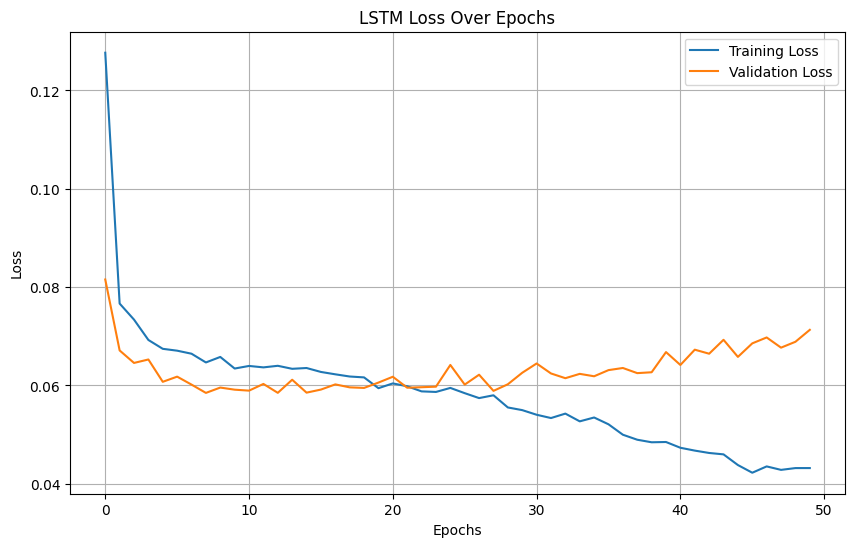

In [137]:
model_loss_plot(history, "LSTM")

#### Make Predictions and Evaluate the Model


In [138]:
lstm_metrics_dict= evaluate_model(lstm_model, X_test, y_test, scaler)
lstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


{'MAE': 3.9292094152301846,
 'MSE': 37.49569319209348,
 'RMSE': 6.123372697467751,
 'MAPE': 3297388814794134.5,
 'R² Score': 0.5072520506069105}

In [ ]:
# Plot the Actual vs Predicted Results
def plot_actual_vs_predicted(model, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:50], label='Actual')
    plt.plot(y_pred[:50], label='Predicted')
    plt.title(f'Actual vs Predicted Over Time {model_name})')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Availability Hrs')
    plt.legend()
    plt.grid(True)
    plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


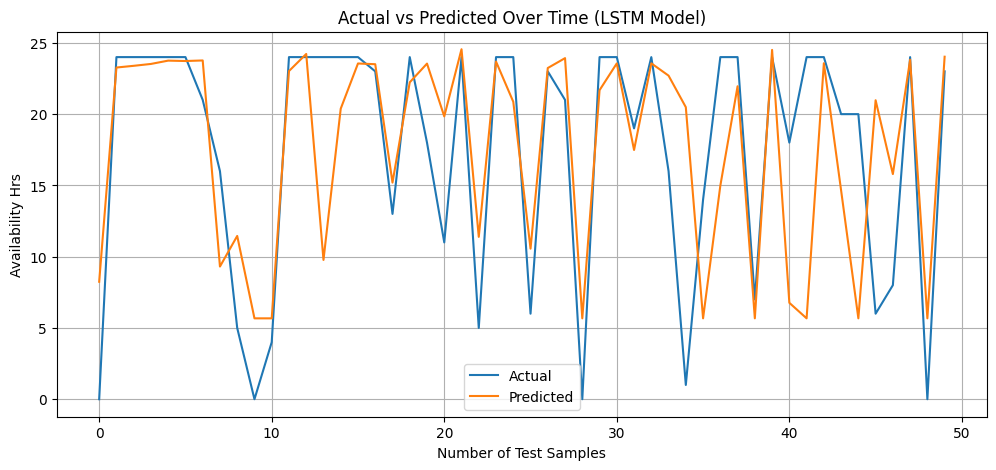

In [140]:
plot_actual_vs_predicted(lstm_model, "LSTM Model")

#### LSTM Tuning With DragonFly Optimisation

In [141]:
domain = [
    (16, 128),      # hidden_units
    (1, 3),         # num_layers
    (0.0, 0.5),     # dropout_rate
    (1e-4, 1e-2),   # learning_rate
    (16, 128)       # batch_size
]

param_names = ["hidden_units", "num_layers", "dropout_rate", "learning_rate", "batch_size"]


In [142]:
# Objective function for Dragonfly
def objective_function(params):
    params= dict(zip(param_names, params))
    print("\n Evaluating with params:", params)
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build LSTM model with given hyperparameters
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])
    
    # Train the model
    model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 0, epochs=50)
        
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    return rmse


In [143]:
# Run Dragonfly optimization with Bayesian optimization (Default is 'bo')
best_val, best_params, history = minimise_function(
    objective_function, domain, max_capital=20
)

best_params_dict = dict(zip(param_names, best_params))
print("Best Parameters:", best_params_dict)
print("Best RMSE:", best_val)

Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 20.0 (return_value)



 Evaluating with params: {'hidden_units': np.float64(37.16439563971873), 'num_layers': np.float64(1.1976021499719485), 'dropout_rate': np.float64(0.3092224016511713), 'learning_rate': np.float64(0.00028300450264439996), 'batch_size': np.float64(111.04661521622107)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 5.702742103138933

 Evaluating with params: {'hidden_units': np.float64(102.3564801660277), 'num_layers': np.float64(2.9479636733507886), 'dropout_rate': np.float64(0.21375306304382286), 'learning_rate': np.float64(0.0035843583784892514), 'batch_size': np.float64(59.66463705588386)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 6.119627639715256

 Evaluating with params: {'hidden_units': np.float64(117.00780247233155), 'num_layers': np.float64(2.2287618038869397), 'dropout_rate': np.float64(0.14283796768452034), 'learning_rate': np.float64(0.0078011203998938445), 'batch_size': np.float64(98.1116984715352)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
RMSE: 5.724955695900038

 Evaluating with params: {'hidden_units': np.float64(74.47785587256372), 'num_layers': np.float64(1.6153072870512797), 'dropout_rate': np.float64(0.050704761108380604), 'learning_rate': np.float64(0.005114501282249116), 'batch_size': np.float64(24.221420093466776)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 6.343081115612407

 Evaluating with params: {'hidden_units': np.float64(50.87610877533661), 'num_layers': np.float64(1.8744209991598106), 'dropout_rate': np.float64(0.43093088057005474), 'learning_rate': np.float64(0.008890532610598715), 'batch_size': np.float64(62.69799841739318)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.970316663988151
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.75), 'dropout_rate': np.float64(0.1875), 'learning_rate': np.float64(0.0038125000000000004), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.672533746715545


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.424146749315656


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.125), 'learning_rate': np.float64(0.00010001888275146485), 'batch_size': np.float64(114.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.7010203156932695


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.521372076638685


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(44.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.489926840611818


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(89.5), 'num_layers': np.float64(1.0625), 'dropout_rate': np.float64(0.46875), 'learning_rate': np.float64(0.00938125), 'batch_size': np.float64(121.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 6.05175866488627


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.455295140343219
#013 (011, 0.550):: curr_max=-5.42415, acqs=[ei:2, ucb:1, ttei:2, add_ucb:1], 


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(2.25), 'dropout_rate': np.float64(0.4375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 5.454477736952103


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 5.478451206669424


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 5.502751504968097


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.75), 'dropout_rate': np.float64(0.125), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 5.55463524008917


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(16.4375), 'num_layers': np.float64(1.0625), 'dropout_rate': np.float64(0.484375), 'learning_rate': np.float64(0.007486328125000001), 'batch_size': np.float64(124.5)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 5.462904912457888


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(114.0), 'num_layers': np.float64(2.75), 'dropout_rate': np.float64(0.0625), 'learning_rate': np.float64(0.0087625), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
RMSE: 6.1407547966088964


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.25), 'dropout_rate': np.float64(0.125), 'learning_rate': np.float64(0.007525000000000001), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 5.77588924402468


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(114.0), 'num_layers': np.float64(2.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.007525000000000001), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 5.723489421168368


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)



 Evaluating with params: {'hidden_units': np.float64(58.0), 'num_layers': np.float64(1.75), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(44.0)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.598519637333927
#022 (021, 1.050):: curr_max=-5.42415, acqs=[ei:8, ucb:2, ttei:4, add_ucb:2], 
Best Parameters: {'hidden_units': np.float64(30.0), 'num_layers': np.float64(1.5), 'dropout_rate': np.float64(0.375), 'learning_rate': np.float64(0.002575), 'batch_size': np.float64(100.0)}
Best RMSE: 5.424146749315656


In [144]:
# Run Dragonfly optimization with Random Method
rand_val, rand_params, rand_history = minimise_function(
    objective_function, domain, max_capital=20, opt_method='rand'
)

rand_params_dict = dict(zip(param_names, rand_params))
print("Best Parameters:", rand_params_dict)
print("Best RMSE:", rand_val)

Optimisation with rand using capital 20.0 (return_value)

 Evaluating with params: {'hidden_units': np.float64(39.721796144868826), 'num_layers': np.float64(2.4344271744985986), 'dropout_rate': np.float64(0.010990303717049177), 'learning_rate': np.float64(0.008061519347625062), 'batch_size': np.float64(42.03879776903103)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 6.201331890697293

 Evaluating with params: {'hidden_units': np.float64(63.22283776050695), 'num_layers': np.float64(1.3642953396621662), 'dropout_rate': np.float64(0.4862672332547066), 'learning_rate': np.float64(0.0018234635847073257), 'batch_size': np.float64(38.3813664127651)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.649397900593173

 Evaluating with params: {'hidden_units': np.float64(110.5341715000798), 'num_layers': np.float64(1.7630720673107343), 'dropout_rate': np.float64(0.3828025918459621), 'learning_rate': np.float64(0.0019488480629490544), 'batch_size': np.float64(36.82248276153989)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 6.091892374165061

 Evaluating with params: {'hidden_units': np.float64(18.336194304866712), 'num_layers': np.float64(2.49949124262636), 'dropout_rate': np.float64(0.4783049826212197), 'learning_rate': np.float64(0.0009423190185868338), 'batch_size': np.float64(68.0075203296948)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.796059151787513

 Evaluating with params: {'hidden_units': np.float64(63.565870707022775), 'num_layers': np.float64(1.4300426674855777), 'dropout_rate': np.float64(0.34807579821034496), 'learning_rate': np.float64(0.009874288045776142), 'batch_size': np.float64(44.3948331013588)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.085600143145096
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>

 Evaluating with params: {'hidden_units': np.float64(113.17789973863364), 'num_layers': np.float64(1.6720244900719812), 'dropout_rate': np.float64(0.4709579034996729), 'learning_rate': np.float64(0.007215000535154553), 'batch_size': np.float64(80.60651284168766)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.9860750541658545

 Evaluating with params: {'hidden_units': np.float64(66.03380475057324), 'num_layers': np.float64(1.7379971536817695), 'dropout_rate': np.float64(0.4163941576705067), 'learning_rate': np.float64(0.009109171558320587), 'batch_size': np.float64(42.94763277482388)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.041955724372269

 Evaluating with params: {'hidden_units': np.float64(114.65543968636493), 'num_layers': np.float64(2.3134430112801354), 'dropout_rate': np.float64(0.16768716958975555), 'learning_rate': np.float64(0.009425152109565254), 'batch_size': np.float64(126.38531734347454)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 5.67517558511785

 Evaluating with params: {'hidden_units': np.float64(118.74972637280875), 'num_layers': np.float64(1.316803288653082), 'dropout_rate': np.float64(0.2621761692468157), 'learning_rate': np.float64(0.008629265761162946), 'batch_size': np.float64(78.021418507568)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 6.045994013869138

 Evaluating with params: {'hidden_units': np.float64(54.656927169069746), 'num_layers': np.float64(2.8627368578240935), 'dropout_rate': np.float64(0.05699878228260863), 'learning_rate': np.float64(0.006956554406023528), 'batch_size': np.float64(33.647133452384594)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 6.001592430072658

 Evaluating with params: {'hidden_units': np.float64(76.62364965637374), 'num_layers': np.float64(2.999544340871032), 'dropout_rate': np.float64(0.027114225030546613), 'learning_rate': np.float64(0.0035306996962647702), 'batch_size': np.float64(104.79022074434701)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 5.78970008376195

 Evaluating with params: {'hidden_units': np.float64(43.12281602232401), 'num_layers': np.float64(1.3863771151529765), 'dropout_rate': np.float64(0.3586979215037291), 'learning_rate': np.float64(0.004565680532186945), 'batch_size': np.float64(69.86162505466973)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 5.62752964116379
#013 (011, 0.550):: curr_max=-5.64940, 

 Evaluating with params: {'hidden_units': np.float64(99.13908951316309), 'num_layers': np.float64(1.1157001871608545), 'dropout_rate': np.float64(0.19645201284100505), 'learning_rate': np.float64(0.007025731139199014), 'batch_size': np.float64(101.70725447346207)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 5.702303390559886

 Evaluating with params: {'hidden_units': np.float64(101.99879728407385), 'num_layers': np.float64(2.4059800660374586), 'dropout_rate': np.float64(0.30420781125998747), 'learning_rate': np.float64(0.009354751835819687), 'batch_size': np.float64(99.66941030901761)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 5.765450904771094

 Evaluating with params: {'hidden_units': np.float64(115.59946653835162), 'num_layers': np.float64(2.538285907240244), 'dropout_rate': np.float64(0.20742119566369355), 'learning_rate': np.float64(0.007527798854459397), 'batch_size': np.float64(88.65063667281396)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 5.5528229614660685

 Evaluating with params: {'hidden_units': np.float64(56.7888610180354), 'num_layers': np.float64(2.3607043917719794), 'dropout_rate': np.float64(0.46859369312760996), 'learning_rate': np.float64(0.0004956477058202955), 'batch_size': np.float64(92.04765510786558)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 5.778176113788253

 Evaluating with params: {'hidden_units': np.float64(73.18773307977922), 'num_layers': np.float64(1.6643907043182897), 'dropout_rate': np.float64(0.23618960497653052), 'learning_rate': np.float64(0.008221430375176373), 'batch_size': np.float64(24.17205964868829)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 6.103796768910817

 Evaluating with params: {'hidden_units': np.float64(36.02537196598906), 'num_layers': np.float64(2.1276193680147237), 'dropout_rate': np.float64(0.41371538540837205), 'learning_rate': np.float64(0.0029876506930075126), 'batch_size': np.float64(105.27114128945354)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.576912438048942

 Evaluating with params: {'hidden_units': np.float64(77.03741918311331), 'num_layers': np.float64(1.013897398265419), 'dropout_rate': np.float64(0.14333033048545274), 'learning_rate': np.float64(0.005967721871624874), 'batch_size': np.float64(28.891628796148872)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.2431091611923595

 Evaluating with params: {'hidden_units': np.float64(58.87044181894437), 'num_layers': np.float64(2.850296293231071), 'dropout_rate': np.float64(0.32318517199099134), 'learning_rate': np.float64(0.0055243634301450125), 'batch_size': np.float64(27.82319192062579)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 6.037945586115773

 Evaluating with params: {'hidden_units': np.float64(87.12653364617867), 'num_layers': np.float64(1.2215334885326325), 'dropout_rate': np.float64(0.038958879397527346), 'learning_rate': np.float64(0.002576257710534362), 'batch_size': np.float64(29.31386580926942)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 5.999683152985569
#022 (021, 1.050):: curr_max=-5.55282, 
Best Parameters: {'hidden_units': np.float64(115.59946653835162), 'num_layers': np.float64(2.538285907240244), 'dropout_rate': np.float64(0.20742119566369355), 'learning_rate': np.float64(0.007527798854459397), 'batch_size': np.float64(88.65063667281396)}
Best RMSE: 5.5528229614660685


In [145]:
best_params_dict

{'hidden_units': np.float64(30.0),
 'num_layers': np.float64(1.5),
 'dropout_rate': np.float64(0.375),
 'learning_rate': np.float64(0.002575),
 'batch_size': np.float64(100.0)}

In [146]:
rand_params_dict

{'hidden_units': np.float64(115.59946653835162),
 'num_layers': np.float64(2.538285907240244),
 'dropout_rate': np.float64(0.20742119566369355),
 'learning_rate': np.float64(0.007527798854459397),
 'batch_size': np.float64(88.65063667281396)}

In [147]:
# Retrain LSTM model with Any Optimiser best_param_dicts

def train_best_lstm_model(params, Optimiser_name="Dragonfly"):
    """
    Args:
    Param: params: dict of best hyperparameters from optimiser,
    Optimiser_name: name of the optimiser (for printing)
       
    Return: trained model and training history"""
    
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build LSTM model with given hyperparameters
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])

    print(f"{Optimiser_name} Model Architecture:")
    model.summary()
    
    # Train the model
    print(f"\n Training {Optimiser_name} Model with best hyperparameters...")
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 1, epochs=50)
    
    return model, history

### Dont forget to change this best_params_dict to rand_params_dict for Random Method

In [148]:
# Retrain model with the Dragonfly best parameters
dragonfly_lstm_model, dragonfly_history = train_best_lstm_model(best_params_dict, "Dragonfly")

Dragonfly Model Architecture:


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_117 (LSTM)                 │ (None, 30)             │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,591 (17.93 KB)

 Trainable params: 4,591 (17.93 KB)

 Non-trainable params: 0 (0.00 B)


 Training Dragonfly Model with best hyperparameters...
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1369 - root_mean_squared_error: 0.3617 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2555
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2556
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0570 - root_mean_squared_error: 0.2386 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2499
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2477
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0556 - root_mean_squared_error: 0.2357 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2450
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0587 - val_root_mean_squared_error: 0.2422
Epoch 7

In [149]:
lstm_metrics_dict

{'MAE': 3.9292094152301846,
 'MSE': 37.49569319209348,
 'RMSE': 6.123372697467751,
 'MAPE': 3297388814794134.5,
 'R² Score': 0.5072520506069105}

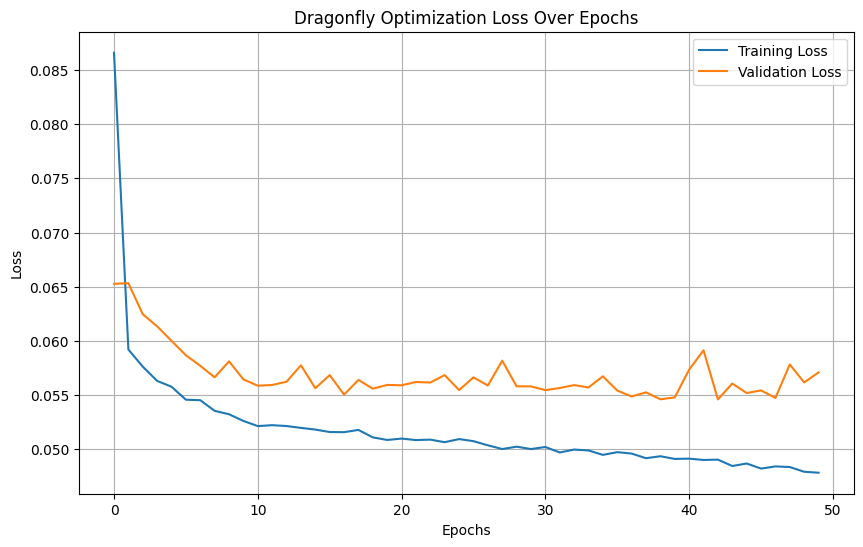

In [150]:
model_loss_plot(dragonfly_history, "Dragonfly Optimization")

In [151]:
# Evaluate the Dragonfly model
dragonfly_lstm_metrics_dict = evaluate_model(dragonfly_lstm_model, X_test, y_test, scaler)
dragonfly_lstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


{'MAE': 3.7795571144933415,
 'MSE': 31.36465898924659,
 'RMSE': 5.600415965733848,
 'MAPE': 2622801979557100.5,
 'R² Score': 0.5878227581714991}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


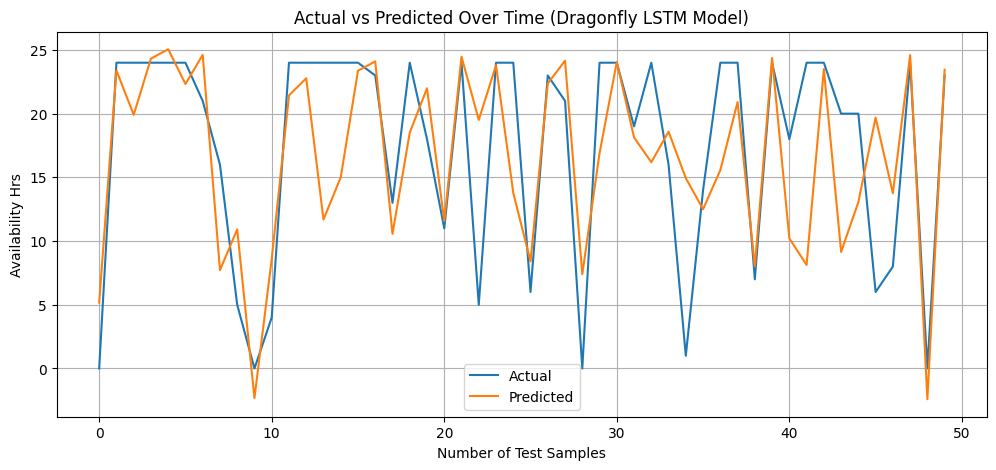

In [152]:
plot_actual_vs_predicted(dragonfly_lstm_model, "Dragonfly LSTM Model")

####  LSTM Hyperparameter Tuning (HyperBand Kerastuner)

In [153]:
def create_lstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [154]:
tuning_base_path = os.path.join('..', 'tuning_params')
if not os.path.exists(tuning_base_path):
    os.makedirs(tuning_base_path)

In [155]:
# Hyperparameter tuning for LSTM
tuner_lstm = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path, 'lstm_tuning'),
    project_name='lstm_hyperparameter_tuning'
)
batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64])

# Perform the hyperparameter search for GRU
tuner_lstm.search(X_train, y_train, epochs=50, validation_split= 0.1, 
                  batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_lstm_hp = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_lstm_hp.values)

Reloading Tuner from ..\tuning_params\lstm_tuning\lstm_hyperparameter_tuning\tuner0.json
Best LSTM Hyperparameters: {'units': 64, 'activation': 'relu', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0009105451871123885, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


In [156]:
# Build the best GRU model
best_lstm_model = tuner_lstm.hypermodel.build(best_lstm_hp)
best_lstm_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_118 (LSTM)                 │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,513 (205.13 KB)

 Trainable params: 52,513 (205.13 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
# Fit the best GRU model
history_lstm = best_lstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.1761 - mae: 0.3295 - val_loss: 0.0706 - val_mae: 0.2113
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0874 - mae: 0.2359 - val_loss: 0.0669 - val_mae: 0.2037
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0837 - mae: 0.2306 - val_loss: 0.0690 - val_mae: 0.2164
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0801 - mae: 0.2219 - val_loss: 0.0617 - val_mae: 0.1859
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0756 - mae: 0.2176 - val_loss: 0.0618 - val_mae: 0.1906
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0733 - mae: 0.2117 - val_loss: 0.0604 - val_mae: 0.1821
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0719 - mae: 0.2121 - val_loss: 0.0595 - val_mae: 0.1783
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0665 - mae: 0.2011 - val_loss: 0.0644 - val_mae: 0.2071
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/

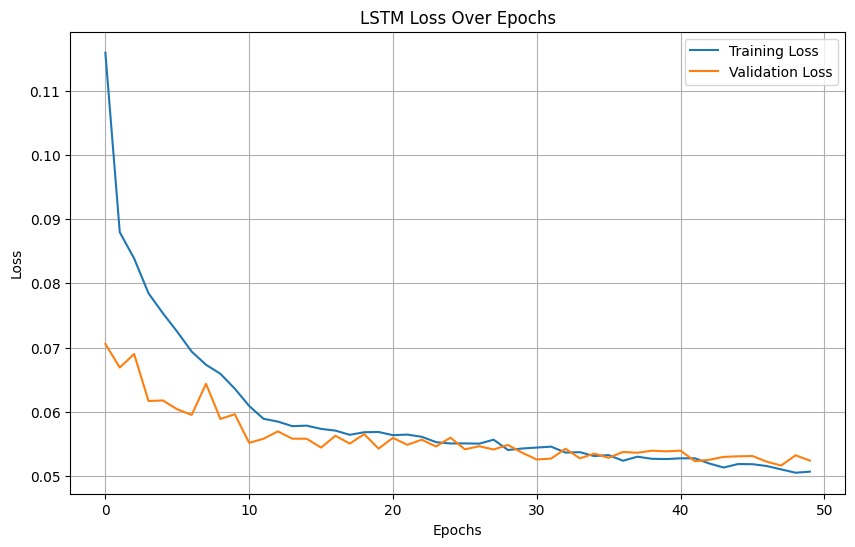

In [ ]:
model_loss_plot(history_lstm, "LSTM (Hyperband)")

In [159]:
lstm_best_metrics_dict= evaluate_model(best_lstm_model, X_test, y_test, scaler)
lstm_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


{'MAE': 3.763675091217975,
 'MSE': 29.90746226959509,
 'RMSE': 5.468771550320518,
 'MAPE': 2924231208010174.0,
 'R² Score': 0.606972442691054}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


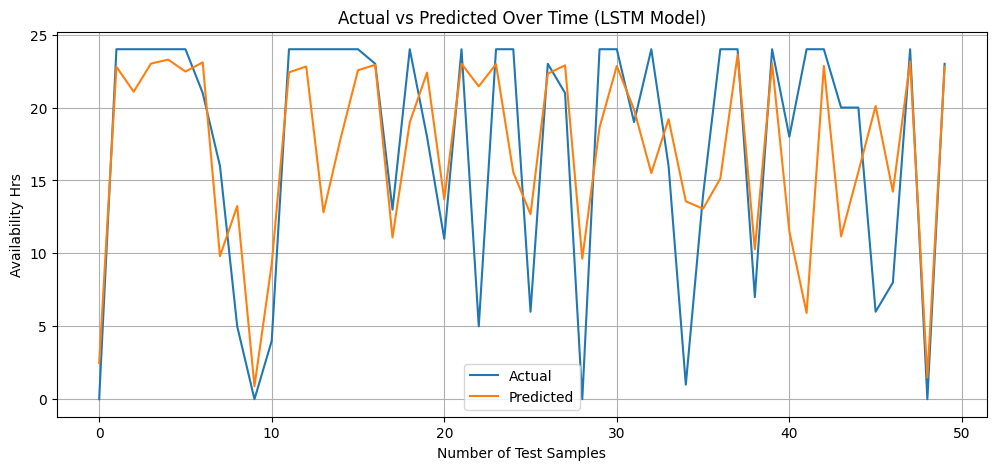

In [ ]:
plot_actual_vs_predicted(best_lstm_model, "LSTM Hyperband")

#### Hyperparamters Tuning with Optuna

In [161]:
import optuna

def objective_optuna(trial):
    # Suggest hyperparameters
    hidden_units = trial.suggest_int("hidden_units", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    # Build model
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    # Train
    model.fit(X_train, y_train,
              epochs=20,
              batch_size=batch_size,
              validation_split=0.2,
              verbose=0)

    # Predict & evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Run optimisation
study = optuna.create_study(direction="minimize")
study.optimize(objective_optuna, n_trials=20)

print("Best Params:", study.best_trial.params)
print("Best RMSE:", study.best_trial.value)

[I 2025-10-19 17:16:54,733] A new study created in memory with name: no-name-7afad1a1-6783-43dc-abae-93ef2f564304
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2025-10-19 17:18:59,094] Trial 0 finished with value: 6.009328364754916 and parameters: {'hidden_units': 105, 'num_layers': 3, 'dropout_rate': 0.22235748995606963, 'learning_rate': 0.0002416724426341556, 'batch_size': 41}. Best is trial 0 with value: 6.009328364754916.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2025-10-19 17:19:55,559] Trial 1 finished with value: 5.644649234270576 and parameters: {'hidden_units': 56, 'num_layers': 3, 'dropout_rate': 0.0067304574123602245, 'learning_rate': 0.0010311152381617323, 'batch_size': 88}. Best is trial 1 with value: 5.644649234270576.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-10-19 17:20:28,101] Trial 2 finished with value: 5.609863351335065 and parameters: {'hidden_units': 34, 'num_layers': 2, 'dropout_rate': 0.13420152133687963, 'learning_rate': 0.0013716694863294947, 'batch_size': 85}. Best is trial 2 with value: 5.609863351335065.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-10-19 17:21:42,827] Trial 3 finished with value: 5.642301799493561 and parameters: {'hidden_units': 67, 'num_layers': 3, 'dropout_rate': 0.4612158490224461, 'learning_rate': 0.0015309861366318356, 'batch_size': 68}. Best is trial 2 with value: 5.609863351335065.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2025-10-19 17:22:50,072] Trial 4 finished with value: 5.594048604771077 and parameters: {'hidden_units': 93, 'num_layers': 2, 'dropout_rate': 0.07004479951435105, 'learning_rate': 0.0011468685933335213, 'batch_size': 79}. Best is trial 4 with value: 5.594048604771077.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-10-19 17:23:27,105] Trial 5 finished with value: 5.526780582183232 and parameters: {'hidden_units': 45, 'num_layers': 2, 'dropout_rate': 0.43868485086003767, 'learning_rate': 0.0033949092017113566, 'batch_size': 74}. Best is trial 5 with value: 5.526780582183232.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-10-19 17:24:06,863] Trial 6 finished with value: 5.585221464170708 and parameters: {'hidden_units': 25, 'num_layers': 1, 'dropout_rate': 0.2870779261086158, 'learning_rate': 0.005319893144062537, 'batch_size': 25}. Best is trial 5 with value: 5.526780582183232.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2025-10-19 17:25:10,653] Trial 7 finished with value: 5.568836223016038 and parameters: {'hidden_units': 76, 'num_layers': 2, 'dropout_rate': 0.36487346682880256, 'learning_rate': 0.0012113563246950532, 'batch_size': 45}. Best is trial 5 with value: 5.526780582183232.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


[I 2025-10-19 17:27:17,384] Trial 8 finished with value: 5.571862274771929 and parameters: {'hidden_units': 127, 'num_layers': 3, 'dropout_rate': 0.09300745473845151, 'learning_rate': 0.002877077802201093, 'batch_size': 85}. Best is trial 5 with value: 5.526780582183232.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-10-19 17:28:55,303] Trial 9 finished with value: 5.526547620284872 and parameters: {'hidden_units': 105, 'num_layers': 2, 'dropout_rate': 0.08272975910195374, 'learning_rate': 0.0014966064178383184, 'batch_size': 50}. Best is trial 9 with value: 5.526547620284872.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2025-10-19 17:29:43,945] Trial 10 finished with value: 5.729275760370369 and parameters: {'hidden_units': 127, 'num_layers': 1, 'dropout_rate': 0.18369748379745254, 'learning_rate': 0.00028246995359044964, 'batch_size': 124}. Best is trial 9 with value: 5.526547620284872.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2025-10-19 17:30:39,144] Trial 11 finished with value: 5.469908690889851 and parameters: {'hidden_units': 49, 'num_layers': 2, 'dropout_rate': 0.49398832747493293, 'learning_rate': 0.008598030484161844, 'batch_size': 62}. Best is trial 11 with value: 5.469908690889851.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-10-19 17:31:26,472] Trial 12 finished with value: 5.466701871831892 and parameters: {'hidden_units': 90, 'num_layers': 1, 'dropout_rate': 0.3214267746640266, 'learning_rate': 0.009038180800631129, 'batch_size': 54}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-10-19 17:32:07,594] Trial 13 finished with value: 5.513258433167571 and parameters: {'hidden_units': 83, 'num_layers': 1, 'dropout_rate': 0.33516562578334946, 'learning_rate': 0.008897110397368938, 'batch_size': 58}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-10-19 17:33:36,869] Trial 14 finished with value: 5.588070650166163 and parameters: {'hidden_units': 62, 'num_layers': 1, 'dropout_rate': 0.4859664761886251, 'learning_rate': 0.009631742544669024, 'batch_size': 16}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-10-19 17:34:28,703] Trial 15 finished with value: 5.482498084006737 and parameters: {'hidden_units': 47, 'num_layers': 1, 'dropout_rate': 0.39736446430577177, 'learning_rate': 0.004939666950028229, 'batch_size': 31}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-10-19 17:34:58,364] Trial 16 finished with value: 5.8637189207731915 and parameters: {'hidden_units': 17, 'num_layers': 2, 'dropout_rate': 0.28436802436785613, 'learning_rate': 0.0005045931372455249, 'batch_size': 105}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-10-19 17:35:40,321] Trial 17 finished with value: 5.517413148252399 and parameters: {'hidden_units': 90, 'num_layers': 1, 'dropout_rate': 0.40936259634302813, 'learning_rate': 0.005816883852270105, 'batch_size': 59}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-10-19 17:36:25,551] Trial 18 finished with value: 5.820579966811817 and parameters: {'hidden_units': 107, 'num_layers': 1, 'dropout_rate': 0.4984516279195761, 'learning_rate': 0.00011747419285234348, 'batch_size': 103}. Best is trial 12 with value: 5.466701871831892.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2437609884.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2025-10-19 17:37:27,303] Trial 19 finished with value: 5.565344018797592 and parameters: {'hidden_units': 52, 'num_layers': 2, 'dropout_rate': 0.3016121975789006, 'learning_rate': 0.002657873572034003, 'batch_size': 61}. Best is trial 12 with value: 5.466701871831892.


Best Params: {'hidden_units': 90, 'num_layers': 1, 'dropout_rate': 0.3214267746640266, 'learning_rate': 0.009038180800631129, 'batch_size': 54}
Best RMSE: 5.466701871831892


In [162]:
lstm_optuna_model, lstm_optuna_history = train_best_lstm_model(study.best_trial.params, "Optuna")

Optuna Model Architecture:


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_156 (LSTM)                 │ (None, 90)             │        35,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,371 (138.17 KB)

 Trainable params: 35,371 (138.17 KB)

 Non-trainable params: 0 (0.00 B)


 Training Optuna Model with best hyperparameters...
Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1440 - root_mean_squared_error: 0.3645 - val_loss: 0.0729 - val_root_mean_squared_error: 0.2700
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0565 - root_mean_squared_error: 0.2376 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2398
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0569 - root_mean_squared_error: 0.2384 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0535 - root_mean_squared_error: 0.2312 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0547 - root_mean_squared_error: 0.2339 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2403
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0533 - root_mean_squared_error: 0.2307 - val_loss: 0.0567 - val_root_mean_squared_error: 

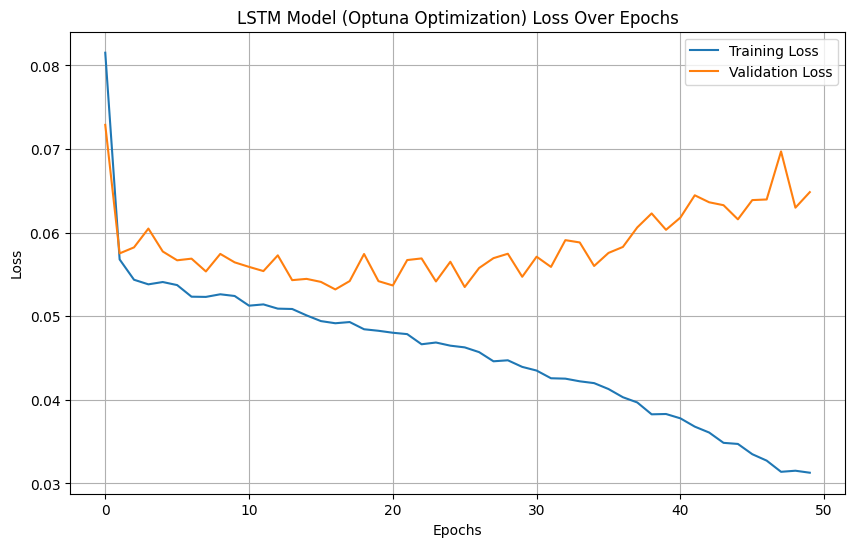

In [163]:
model_loss_plot(lstm_optuna_history, "LSTM Model (Optuna Optimization)")

In [164]:
# Evaluate the Dragonfly model
lstm_optuna_metrics = evaluate_model(lstm_optuna_model, X_test, y_test, scaler)
lstm_optuna_metrics

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


{'MAE': 4.063699191743201,
 'MSE': 36.67524676216875,
 'RMSE': 6.056009144822087,
 'MAPE': 2840705253207890.5,
 'R² Score': 0.518033910109045}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


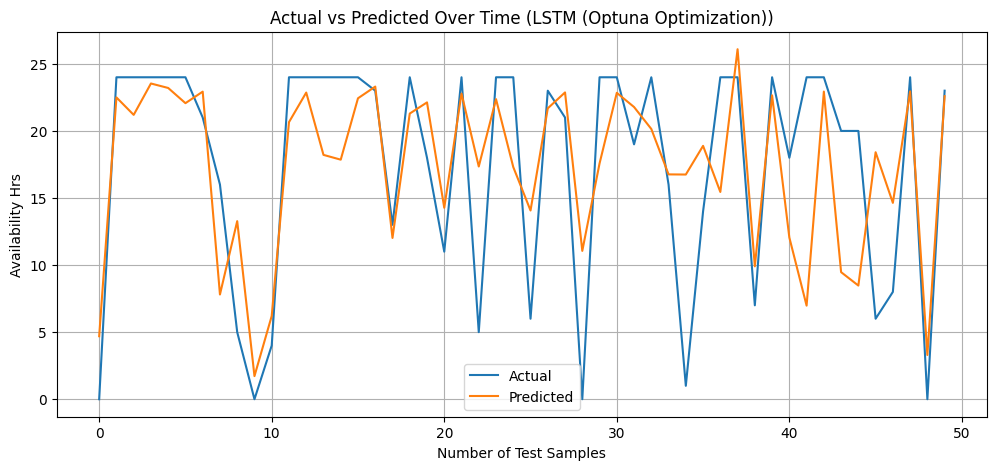

In [165]:
plot_actual_vs_predicted(lstm_optuna_model, "LSTM (Optuna Optimization)")

### GRU Model Training

In [166]:
#Build the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add((GRU(32)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [167]:
# Model training and evaluation
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
gru_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 24, 128)        │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,705 (268.38 KB)

 Trainable params: 68,705 (268.38 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
history_gru = gru_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.2604 - root_mean_squared_error: 0.3874 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2488
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0747 - root_mean_squared_error: 0.2634 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2486
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0668 - root_mean_squared_error: 0.2541 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2400
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0626 - root_mean_squared_error: 0.2472 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2462
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0611 - root_mean_squared_error: 0.2441 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2387
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0592 - root_mean_squared_error: 0.2404 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2370
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29

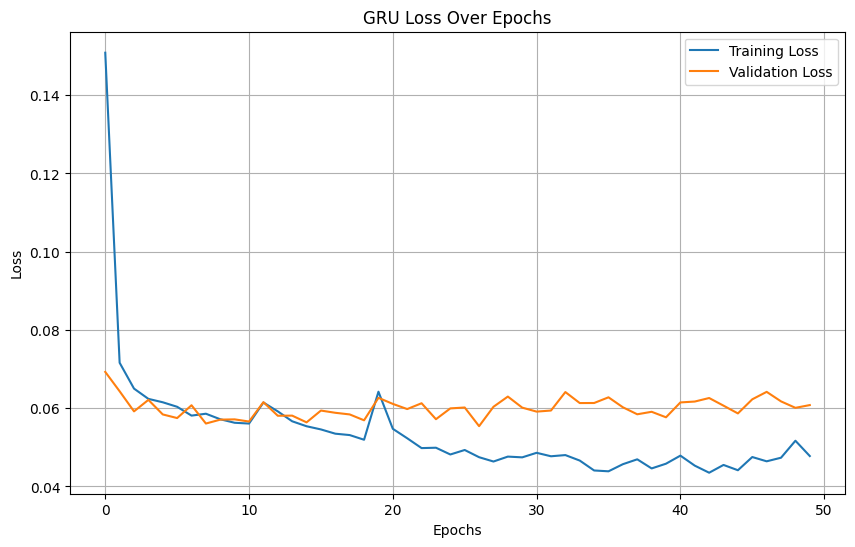

In [169]:
model_loss_plot(history_gru, "GRU")

In [170]:
gru_metrics_dict = evaluate_model(gru_model, X_test, y_test, scaler)
gru_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


{'MAE': 3.988481815543741,
 'MSE': 32.89938508524876,
 'RMSE': 5.735798556892385,
 'MAPE': 3121542002779042.0,
 'R² Score': 0.5676542248732643}

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


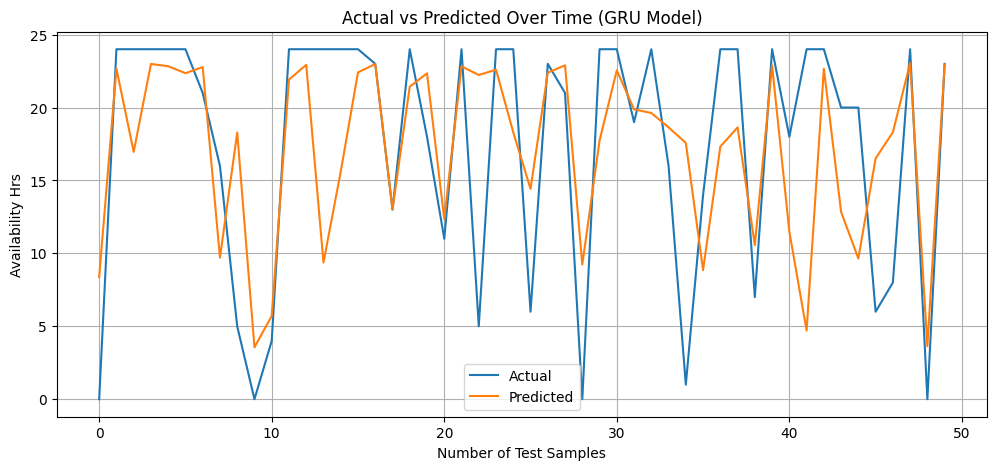

In [171]:
plot_actual_vs_predicted(gru_model, "GRU Model")

#### GRU DragonFly Optimisation 

In [172]:
# Retrain GRU model with Any Optimiser best_param_dicts

def train_best_gru_model(params, Optimiser_name="Dragonfly"):
    """
    Args:
    Param: params: dict of best hyperparameters from optimiser,
    Optimiser_name: name of the optimiser (for printing)
       
    Return: trained model and training history"""
    
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build BiLSTM model with given hyperparameters
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=(num_layers > 1)), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(Bidirectional(LSTM(hidden_units, return_sequences=(i < num_layers - 1))))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])

    print(f"{Optimiser_name} Model Architecture:")
    model.summary()
    
    # Train the model
    print(f"\n Training {Optimiser_name} Model with best hyperparameters...")
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 1, epochs=50)
    
    return model, history

In [173]:
# Objective function for Dragonfly
def objective_function(params):
    params= dict(zip(param_names, params))
    print("\n Evaluating with params:", params)
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build GRU model with given hyperparameters
    model = Sequential()
    model.add(GRU(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(GRU(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])
    
    # Train the model
    model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 0, epochs=50)
        
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    return rmse


In [175]:
# Run Dragonfly optimization
best_val, best_gru_params, history = minimise_function(
    objective_function, domain, max_capital=20, opt_method='rand'
)

best_params_dict = dict(zip(param_names, best_gru_params))
print("Best Parameters:", best_params_dict)
print("Best RMSE:", best_val)

Optimisation with rand using capital 20.0 (return_value)



 Evaluating with params: {'hidden_units': np.float64(75.73283947254015), 'num_layers': np.float64(1.3327272145628513), 'dropout_rate': np.float64(0.28195118376617256), 'learning_rate': np.float64(0.007666089277865062), 'batch_size': np.float64(99.59910085318336)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 6.583597867749853

 Evaluating with params: {'hidden_units': np.float64(118.20216902179952), 'num_layers': np.float64(1.3809740013667977), 'dropout_rate': np.float64(0.4821265461571649), 'learning_rate': np.float64(0.005299337060407167), 'batch_size': np.float64(115.17850045062612)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 6.383579775038987

 Evaluating with params: {'hidden_units': np.float64(103.64991074163932), 'num_layers': np.float64(1.7096088214789849), 'dropout_rate': np.float64(0.05685455106564363), 'learning_rate': np.float64(0.0025239714474477163), 'batch_size': np.float64(99.87434060552533)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.861891895971463

 Evaluating with params: {'hidden_units': np.float64(33.21798168633774), 'num_layers': np.float64(2.557931941243057), 'dropout_rate': np.float64(0.2763666013746765), 'learning_rate': np.float64(0.008651979442075287), 'batch_size': np.float64(30.606537012286207)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 6.047613689416078

 Evaluating with params: {'hidden_units': np.float64(60.069236662273994), 'num_layers': np.float64(2.9347873961049036), 'dropout_rate': np.float64(0.015126676042435061), 'learning_rate': np.float64(0.009008285803589531), 'batch_size': np.float64(41.52052240621044)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 5.774200448097385
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>

 Evaluating with params: {'hidden_units': np.float64(123.93388104687797), 'num_layers': np.float64(2.617152225115751), 'dropout_rate': np.float64(0.21384228563694146), 'learning_rate': np.float64(0.003852903989845344), 'batch_size': np.float64(118.95472630574783)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
RMSE: 6.130365762003847

 Evaluating with params: {'hidden_units': np.float64(106.68816127615253), 'num_layers': np.float64(2.4472989370245313), 'dropout_rate': np.float64(0.02800149073903646), 'learning_rate': np.float64(0.007790548326821477), 'batch_size': np.float64(53.867678519934046)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 5.63634318169568

 Evaluating with params: {'hidden_units': np.float64(19.500112132260174), 'num_layers': np.float64(2.3581658795481806), 'dropout_rate': np.float64(0.19048389422401157), 'learning_rate': np.float64(0.00643124106129741), 'batch_size': np.float64(106.488241095517)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 5.887580220471748

 Evaluating with params: {'hidden_units': np.float64(31.794630048149365), 'num_layers': np.float64(2.545654630977192), 'dropout_rate': np.float64(0.28869501738875947), 'learning_rate': np.float64(0.006481614497106719), 'batch_size': np.float64(78.57213515743935)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 5.956565609816384

 Evaluating with params: {'hidden_units': np.float64(106.76866598925449), 'num_layers': np.float64(1.398639360524549), 'dropout_rate': np.float64(0.48649702906867487), 'learning_rate': np.float64(0.009656532180602397), 'batch_size': np.float64(117.11605476893536)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 6.456626337149661

 Evaluating with params: {'hidden_units': np.float64(90.00873115105281), 'num_layers': np.float64(1.793095661716094), 'dropout_rate': np.float64(0.40194647477176076), 'learning_rate': np.float64(0.006129598384967333), 'batch_size': np.float64(106.24985573086289)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE: 6.539577513164252

 Evaluating with params: {'hidden_units': np.float64(76.37926010294825), 'num_layers': np.float64(2.365831746426111), 'dropout_rate': np.float64(0.00478283036434779), 'learning_rate': np.float64(0.0027013502546185324), 'batch_size': np.float64(32.04663577870016)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 6.31848187435573
#013 (011, 0.550):: curr_max=-5.63634, 

 Evaluating with params: {'hidden_units': np.float64(18.899626772662703), 'num_layers': np.float64(1.767930434667244), 'dropout_rate': np.float64(0.2004291502145803), 'learning_rate': np.float64(0.0025758300155803125), 'batch_size': np.float64(83.71393371935497)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.525128638599408

 Evaluating with params: {'hidden_units': np.float64(28.375533257462145), 'num_layers': np.float64(2.9232839272537934), 'dropout_rate': np.float64(0.10785322122266972), 'learning_rate': np.float64(0.006691522180317183), 'batch_size': np.float64(38.01216767583948)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.9818618301376105

 Evaluating with params: {'hidden_units': np.float64(79.45764620675165), 'num_layers': np.float64(1.588663137831331), 'dropout_rate': np.float64(0.49154073537622045), 'learning_rate': np.float64(0.0036676964649679632), 'batch_size': np.float64(36.17995949105321)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 6.274724811374863

 Evaluating with params: {'hidden_units': np.float64(25.346626226404325), 'num_layers': np.float64(1.6275820774826373), 'dropout_rate': np.float64(0.13533172655681674), 'learning_rate': np.float64(0.008011724828547426), 'batch_size': np.float64(40.520343710256626)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 5.823028770237933

 Evaluating with params: {'hidden_units': np.float64(109.1887114173865), 'num_layers': np.float64(2.9398096661640913), 'dropout_rate': np.float64(0.15534532627558456), 'learning_rate': np.float64(0.008514046707103476), 'batch_size': np.float64(95.83551896430399)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 5.809724094513887

 Evaluating with params: {'hidden_units': np.float64(71.46297178277084), 'num_layers': np.float64(2.825805274825599), 'dropout_rate': np.float64(0.4709430192741833), 'learning_rate': np.float64(0.008339738412793058), 'batch_size': np.float64(64.90084448788288)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 5.765344745221553

 Evaluating with params: {'hidden_units': np.float64(18.606639603997692), 'num_layers': np.float64(2.95773632262915), 'dropout_rate': np.float64(0.26691192942453257), 'learning_rate': np.float64(0.003272931528187896), 'batch_size': np.float64(34.40502389037235)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.872676429994205

 Evaluating with params: {'hidden_units': np.float64(78.34090699509262), 'num_layers': np.float64(1.8801120178103856), 'dropout_rate': np.float64(0.03287074583225219), 'learning_rate': np.float64(0.006463390910156922), 'batch_size': np.float64(110.15140464870741)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.211107683225706

 Evaluating with params: {'hidden_units': np.float64(41.97547660119351), 'num_layers': np.float64(2.827758372534044), 'dropout_rate': np.float64(0.047128108192985185), 'learning_rate': np.float64(0.0014384828189023746), 'batch_size': np.float64(121.88715648752141)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 5.496808959620582
#022 (021, 1.050):: curr_max=-5.49681, 
Best Parameters: {'hidden_units': np.float64(41.97547660119351), 'num_layers': np.float64(2.827758372534044), 'dropout_rate': np.float64(0.047128108192985185), 'learning_rate': np.float64(0.0014384828189023746), 'batch_size': np.float64(121.88715648752141)}
Best RMSE: 5.496808959620582


In [176]:
# Retrain model with the Dragonfly best parameters
dragonfly_gru_model, dragonfly_gru_history = train_best_gru_model(best_params_dict, "Dragonfly")

Dragonfly Model Architecture:


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 24, 82)         │        16,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 82)             │        40,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 16)             │         1,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,089 (226.91 KB)

 Trainable params: 58,089 (226.91 KB)

 Non-trainable params: 0 (0.00 B)


 Training Dragonfly Model with best hyperparameters...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.4300 - root_mean_squared_error: 0.4248 - val_loss: 0.2128 - val_root_mean_squared_error: 0.2556
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1889 - root_mean_squared_error: 0.2513 - val_loss: 0.1380 - val_root_mean_squared_error: 0.2519
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1276 - root_mean_squared_error: 0.2527 - val_loss: 0.1019 - val_root_mean_squared_error: 0.2513
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0973 - root_mean_squared_error: 0.2527 - val_loss: 0.0838 - val_root_mean_squared_error: 0.2498
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0804 - root_mean_squared_error: 0.2481 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2498
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0730 - root_mean_squared_error: 0.2481 - val_loss: 0.0706 - val_root_mean_squared_error: 0.2501
Ep

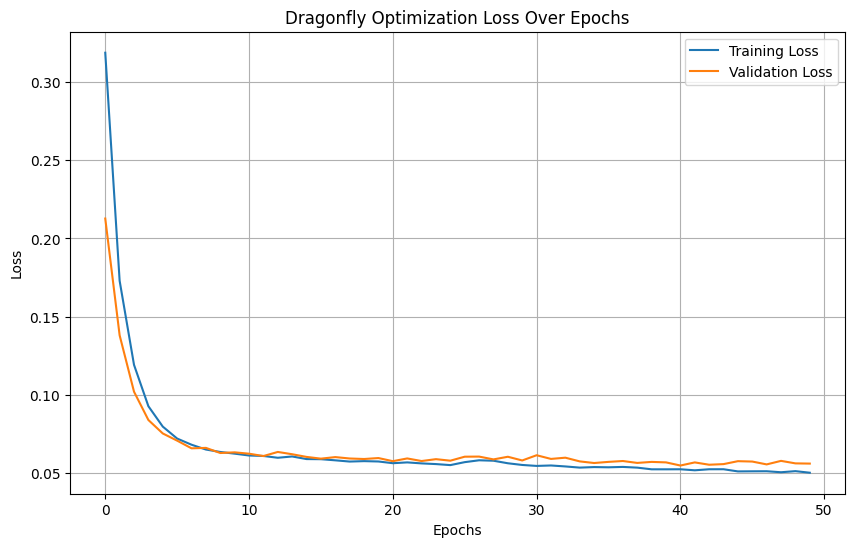

In [177]:
model_loss_plot(dragonfly_gru_history, "Dragonfly Optimization")

In [178]:
# Evaluate the Dragonfly model
dragonfly_gru_metrics_dict = evaluate_model(dragonfly_gru_model, X_test, y_test, scaler)
dragonfly_gru_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


{'MAE': 3.8773436016090748,
 'MSE': 30.793132831539666,
 'RMSE': 5.549156046782219,
 'MAPE': 2744946734287826.5,
 'R² Score': 0.5953334432198283}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


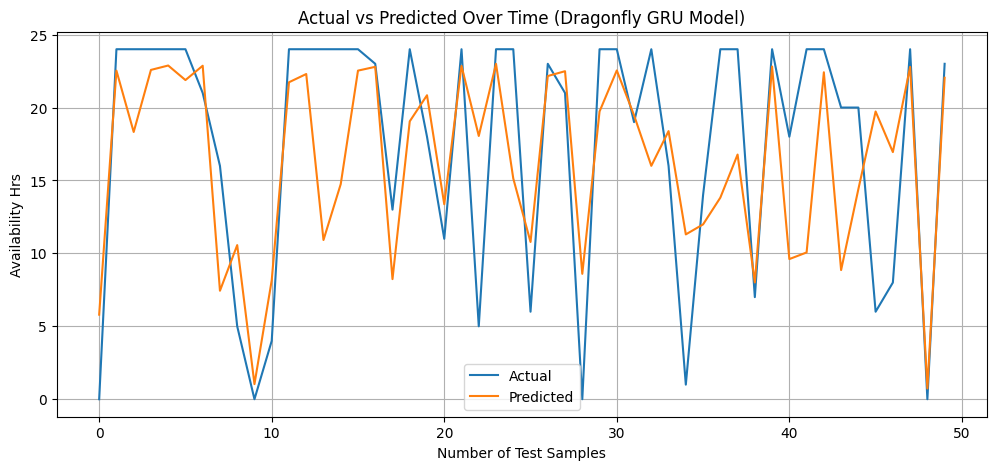

In [179]:
plot_actual_vs_predicted(dragonfly_gru_model, "Dragonfly GRU Model")

#### GRU Optuna Optimisation Hyperparamters 

In [180]:
import optuna

def objective_optuna(trial):
    # Suggest hyperparameters
    hidden_units = trial.suggest_int("hidden_units", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    # Build model
    model = Sequential()
    model.add(GRU(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(GRU(hidden_units, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    # Train
    model.fit(X_train, y_train,
              epochs=20,
              batch_size=batch_size,
              validation_split=0.2,
              verbose=0)

    # Predict & evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Run optimisation
study = optuna.create_study(direction="minimize")
study.optimize(objective_optuna, n_trials=20)

print("Best Params:", study.best_trial.params)
print("Best RMSE:", study.best_trial.value)

[I 2025-10-19 18:38:14,644] A new study created in memory with name: no-name-70ec32bd-151e-4c0c-b0ce-ab6939ac9530
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


[I 2025-10-19 18:41:12,214] Trial 0 finished with value: 5.6863516240645975 and parameters: {'hidden_units': 67, 'num_layers': 3, 'dropout_rate': 0.2564746112044573, 'learning_rate': 0.0001249174113989851, 'batch_size': 16}. Best is trial 0 with value: 5.6863516240645975.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-10-19 18:42:27,072] Trial 1 finished with value: 5.594523598055521 and parameters: {'hidden_units': 52, 'num_layers': 2, 'dropout_rate': 0.04260077101418053, 'learning_rate': 0.00018247166521088835, 'batch_size': 34}. Best is trial 1 with value: 5.594523598055521.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-10-19 18:43:05,263] Trial 2 finished with value: 5.58699611993311 and parameters: {'hidden_units': 49, 'num_layers': 2, 'dropout_rate': 0.26957392354262466, 'learning_rate': 0.0006818921065349007, 'batch_size': 126}. Best is trial 2 with value: 5.58699611993311.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


[I 2025-10-19 18:44:59,231] Trial 3 finished with value: 5.800923095283867 and parameters: {'hidden_units': 67, 'num_layers': 3, 'dropout_rate': 0.10032593645492294, 'learning_rate': 0.00010957322199363486, 'batch_size': 59}. Best is trial 2 with value: 5.58699611993311.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2025-10-19 18:45:49,071] Trial 4 finished with value: 5.5938884667784645 and parameters: {'hidden_units': 123, 'num_layers': 1, 'dropout_rate': 0.010410479706896347, 'learning_rate': 0.0010201985560235574, 'batch_size': 91}. Best is trial 2 with value: 5.58699611993311.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2025-10-19 18:46:41,560] Trial 5 finished with value: 5.621622802246154 and parameters: {'hidden_units': 17, 'num_layers': 3, 'dropout_rate': 0.14093123988350903, 'learning_rate': 0.0017346086689486767, 'batch_size': 100}. Best is trial 2 with value: 5.58699611993311.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2025-10-19 18:47:11,528] Trial 6 finished with value: 5.678475037137447 and parameters: {'hidden_units': 74, 'num_layers': 1, 'dropout_rate': 0.3500882063167173, 'learning_rate': 0.00015625476230657568, 'batch_size': 112}. Best is trial 2 with value: 5.58699611993311.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-10-19 18:47:45,123] Trial 7 finished with value: 5.5807873395650525 and parameters: {'hidden_units': 61, 'num_layers': 1, 'dropout_rate': 0.37037437181287775, 'learning_rate': 0.0011027222910258085, 'batch_size': 99}. Best is trial 7 with value: 5.5807873395650525.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


[I 2025-10-19 18:49:20,654] Trial 8 finished with value: 5.560507529421704 and parameters: {'hidden_units': 54, 'num_layers': 3, 'dropout_rate': 0.11157051887097486, 'learning_rate': 0.00045255966495991027, 'batch_size': 59}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


[I 2025-10-19 18:51:26,465] Trial 9 finished with value: 5.642162506602455 and parameters: {'hidden_units': 114, 'num_layers': 3, 'dropout_rate': 0.03879258822716514, 'learning_rate': 0.0012448414386050325, 'batch_size': 112}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2025-10-19 18:52:38,927] Trial 10 finished with value: 5.568604218940096 and parameters: {'hidden_units': 93, 'num_layers': 2, 'dropout_rate': 0.482802405912692, 'learning_rate': 0.008908757944574046, 'batch_size': 63}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-10-19 18:53:55,602] Trial 11 finished with value: 5.711992545002026 and parameters: {'hidden_units': 93, 'num_layers': 2, 'dropout_rate': 0.49531228460274507, 'learning_rate': 0.006697210897570835, 'batch_size': 63}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2025-10-19 18:55:21,161] Trial 12 finished with value: 5.681575880105906 and parameters: {'hidden_units': 92, 'num_layers': 2, 'dropout_rate': 0.4782076796482486, 'learning_rate': 0.00725708210379955, 'batch_size': 47}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


[I 2025-10-19 18:56:17,524] Trial 13 finished with value: 5.652254843679335 and parameters: {'hidden_units': 34, 'num_layers': 2, 'dropout_rate': 0.17026680292998825, 'learning_rate': 0.00042545947338689624, 'batch_size': 72}. Best is trial 8 with value: 5.560507529421704.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


[I 2025-10-19 18:57:52,280] Trial 14 finished with value: 5.535948137462418 and parameters: {'hidden_units': 89, 'num_layers': 3, 'dropout_rate': 0.40396503282946694, 'learning_rate': 0.0030043346151026914, 'batch_size': 80}. Best is trial 14 with value: 5.535948137462418.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2025-10-19 18:59:07,705] Trial 15 finished with value: 5.592183738992005 and parameters: {'hidden_units': 81, 'num_layers': 3, 'dropout_rate': 0.37210708284028554, 'learning_rate': 0.002991152370566762, 'batch_size': 83}. Best is trial 14 with value: 5.535948137462418.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2025-10-19 19:00:28,881] Trial 16 finished with value: 5.581838615591528 and parameters: {'hidden_units': 37, 'num_layers': 3, 'dropout_rate': 0.20086022846535, 'learning_rate': 0.00041663763486486215, 'batch_size': 43}. Best is trial 14 with value: 5.535948137462418.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


[I 2025-10-19 19:02:31,477] Trial 17 finished with value: 5.498523654603253 and parameters: {'hidden_units': 109, 'num_layers': 3, 'dropout_rate': 0.3120155883784733, 'learning_rate': 0.00275580542770912, 'batch_size': 81}. Best is trial 17 with value: 5.498523654603253.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-10-19 19:04:34,293] Trial 18 finished with value: 5.747177532929355 and parameters: {'hidden_units': 109, 'num_layers': 3, 'dropout_rate': 0.3190314620869539, 'learning_rate': 0.003354870837303209, 'batch_size': 80}. Best is trial 17 with value: 5.498523654603253.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\2369024148.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


[I 2025-10-19 19:06:15,922] Trial 19 finished with value: 5.749764477998543 and parameters: {'hidden_units': 102, 'num_layers': 3, 'dropout_rate': 0.41159346084162046, 'learning_rate': 0.003806745167596485, 'batch_size': 76}. Best is trial 17 with value: 5.498523654603253.


Best Params: {'hidden_units': 109, 'num_layers': 3, 'dropout_rate': 0.3120155883784733, 'learning_rate': 0.00275580542770912, 'batch_size': 81}
Best RMSE: 5.498523654603253


In [181]:
gru_optuna_model, gru_optuna_history = train_best_gru_model(study.best_trial.params, "Optuna")

Optuna Model Architecture:


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 24, 218)        │       102,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 24, 218)        │       286,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 24, 16)         │         3,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 218)            │       109,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │         3,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,937 (1.93 MB)

 Trainable params: 504,937 (1.93 MB)

 Non-trainable params: 0 (0.00 B)


 Training Optuna Model with best hyperparameters...
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - loss: 0.6178 - root_mean_squared_error: 0.4642 - val_loss: 0.1795 - val_root_mean_squared_error: 0.2531
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.1741 - root_mean_squared_error: 0.2904 - val_loss: 0.1084 - val_root_mean_squared_error: 0.2621
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.1096 - root_mean_squared_error: 0.2787 - val_loss: 0.0796 - val_root_mean_squared_error: 0.2515
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0925 - root_mean_squared_error: 0.2808 - val_loss: 0.0716 - val_root_mean_squared_error: 0.2524
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0803 - root_mean_squared_error: 0.2714 - val_loss: 0.0686 - val_root_mean_squared_error: 0.2538
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0754 - root_mean_squared_error: 0.2676 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2554
Ep

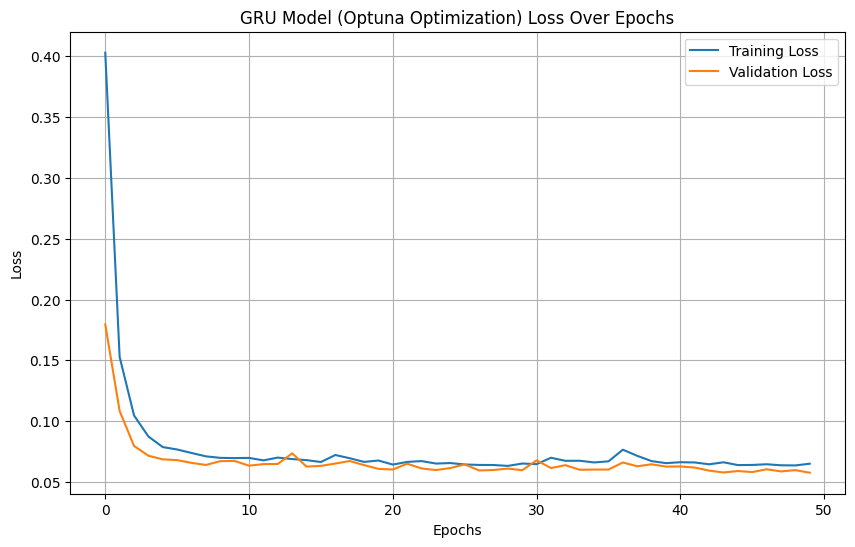

In [182]:
model_loss_plot(gru_optuna_history, "GRU Model (Optuna Optimization)")

In [183]:
# Evaluate the Dragonfly model
gru_optuna_metrics = evaluate_model(gru_optuna_model, X_test, y_test, scaler)
gru_optuna_metrics

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


{'MAE': 3.9639313756203163,
 'MSE': 31.960583068118563,
 'RMSE': 5.653369178473891,
 'MAPE': 3875901477703879.5,
 'R² Score': 0.5799914489500964}

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


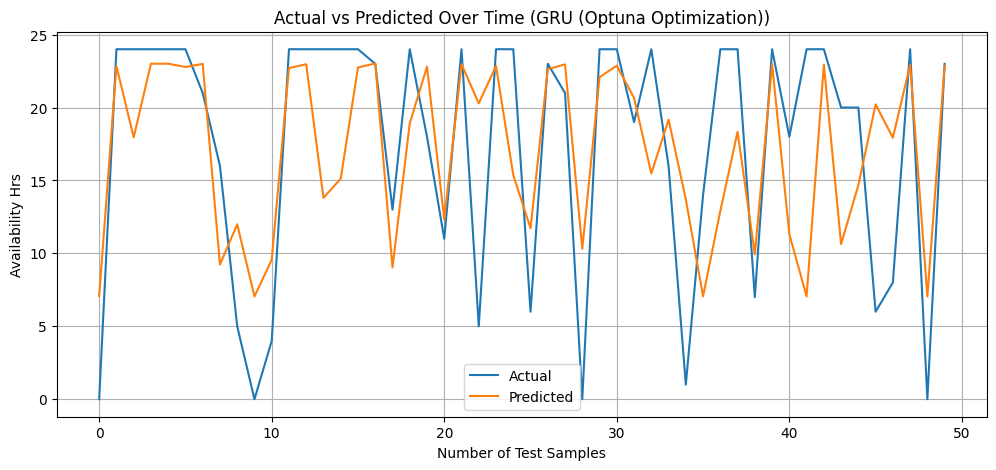

In [184]:
plot_actual_vs_predicted(gru_optuna_model, "GRU (Optuna Optimization)")

#### GRU Hyperband Hyperparamters Tuning

In [185]:
def create_gru_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation= hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model


In [186]:
# Hyperparameter tuning for GRU
tuner_gru = kt.Hyperband(
    create_gru_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory=os.path.join(tuning_base_path,'gru_tuning'),
    project_name='gru_hyperparameter_tuning'
)

# Perform the hyperparameter search for GRU
tuner_gru.search(X_train, y_train, epochs=50, 
                 validation_split= 0.1, 
                 batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_gru_hp = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print("Best GRU Hyperparameters:", best_gru_hp.values)

Reloading Tuner from ..\tuning_params\gru_tuning\gru_hyperparameter_tuning\tuner0.json
Best GRU Hyperparameters: {'units': 96, 'activation': 'tanh', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008367811950596679, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [187]:
# Build the best GRU model
best_gru_model = tuner_gru.hypermodel.build(best_gru_hp)
best_gru_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_89 (GRU)                    │ (None, 24, 96)         │        30,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_90 (GRU)                    │ (None, 96)             │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,681 (342.50 KB)

 Trainable params: 87,681 (342.50 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
# Fit the best GRU model
history_gru = best_gru_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.1706 - mae: 0.3205 - val_loss: 0.0653 - val_mae: 0.1885
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0883 - mae: 0.2342 - val_loss: 0.0614 - val_mae: 0.1922
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0767 - mae: 0.2175 - val_loss: 0.0598 - val_mae: 0.1826
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0750 - mae: 0.2141 - val_loss: 0.0601 - val_mae: 0.1842
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0699 - mae: 0.2074 - val_loss: 0.0571 - val_mae: 0.1822
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0699 - mae: 0.2070 - val_loss: 0.0589 - val_mae: 0.1898
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0667 - mae: 0.2015 - val_loss: 0.0571 - val_mae: 0.1712
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0626 - mae: 0.1951 - val_loss: 0.0577 - val_mae: 0.1843
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/

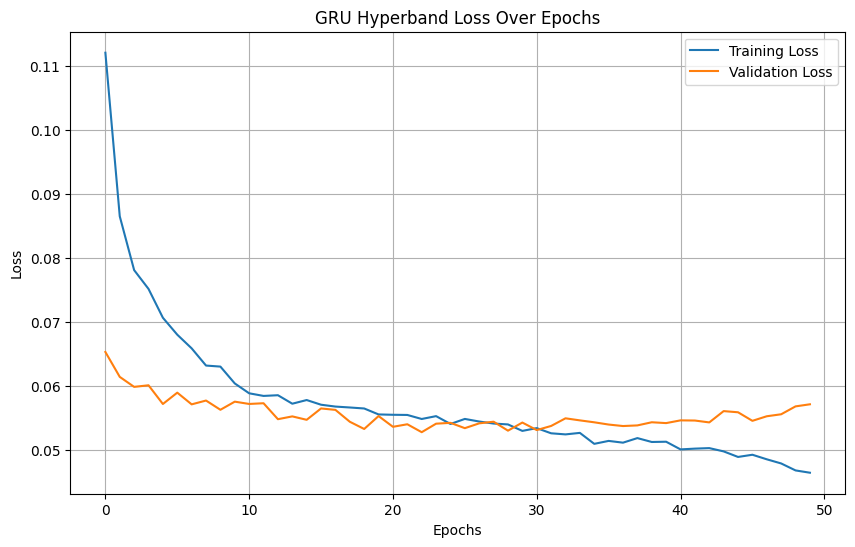

In [189]:
model_loss_plot(history_gru, "GRU Hyperband")

In [190]:
gru_best_metrics_dict = evaluate_model(best_gru_model, X_test, y_test, scaler)
gru_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


{'MAE': 3.8377380075409797,
 'MSE': 31.01552062546708,
 'RMSE': 5.56915798173001,
 'MAPE': 3176200356107837.0,
 'R² Score': 0.5924109441246284}

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


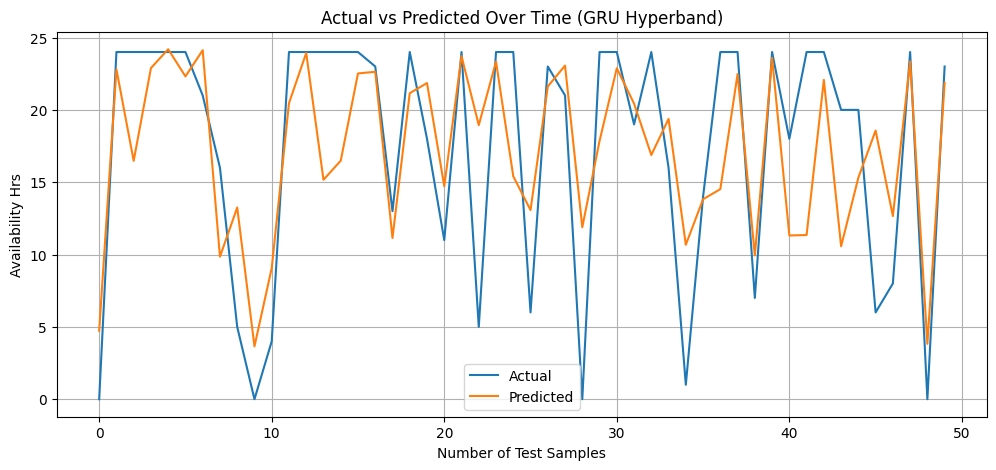

In [191]:
plot_actual_vs_predicted(best_gru_model, "GRU Hyperband")

### BiLSTM Model Training

In [192]:
#Build the Bidirectional LSTM(model
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add((Bidirectional(LSTM(32))))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(loss= MeanSquaredError(), optimizer=Adam(learning_rate= 0.005, clipvalue= 1.0),
                  metrics= [RootMeanSquaredError()])
    return model

In [193]:
# Model training and evaluation
bilstm_model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))  # Define input shape
bilstm_model.summary()

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [194]:
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, verbose=1)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0.2622 - root_mean_squared_error: 0.3773 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2690
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0839 - root_mean_squared_error: 0.2742 - val_loss: 0.0694 - val_root_mean_squared_error: 0.2586
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0758 - root_mean_squared_error: 0.2714 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2533
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0717 - root_mean_squared_error: 0.2651 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2473
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0720 - root_mean_squared_error: 0.2656 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2474
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0688 - root_mean_squared_error: 0.2598 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2478
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35

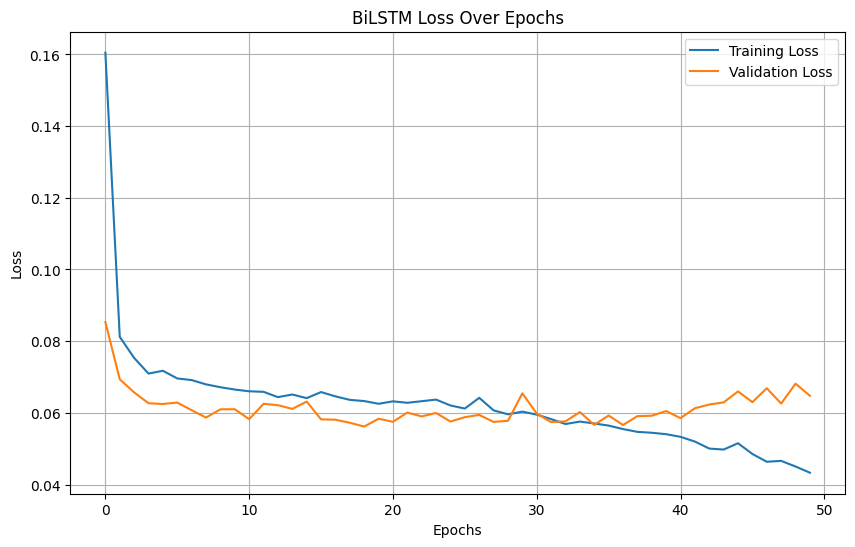

In [195]:
model_loss_plot(history_bilstm, "BiLSTM")

In [196]:
bilstm_metrics_dict= evaluate_model(bilstm_model, X_test, y_test, scaler)
bilstm_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


{'MAE': 4.427778307397225,
 'MSE': 35.168578388807376,
 'RMSE': 5.9303101427166,
 'MAPE': 3258554698165018.0,
 'R² Score': 0.5378337241193053}

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


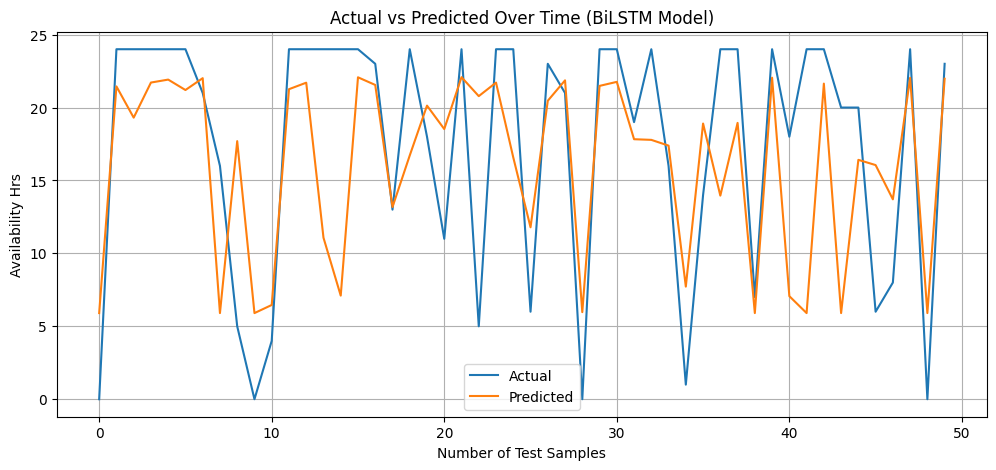

In [197]:
plot_actual_vs_predicted(bilstm_model, "BiLSTM Model")

#### BiLSTM Hyperband Hyperparamter Tuning

In [198]:
def create_bilstm_model(hp):
    model = Sequential()
    
    # Hyperparameters to tune
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
            return_sequences=True
        ),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    model.add(Bidirectional(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        )
    ))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))  # <-- Add this line for regression output
    # Learning rate tuning
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse', metrics=['mae'])
    
    return model

In [199]:
# Hyperparameter tuning for BiLSTM
tuner_bilstm = kt.Hyperband(
    create_bilstm_model,
    objective='val_loss',  # Optimize validation loss
    max_epochs=10,
    factor=3,
    directory= os.path.join(tuning_base_path, 'bilstm_tuning'),
    project_name='bilstm_hyperparameter_tuning'
)

# Perform the hyperparameter search for BiLSTM
tuner_bilstm.search(X_train, y_train, epochs=50, validation_split=0.1, 
                    batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_bilstm_hp = tuner_bilstm.get_best_hyperparameters(num_trials=1)[0]
print("Best BiLSTM Hyperparameters:", best_bilstm_hp.values)



Reloading Tuner from ..\tuning_params\bilstm_tuning\bilstm_hyperparameter_tuning\tuner0.json
Best BiLSTM Hyperparameters: {'units': 128, 'activation': 'relu', 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001325242185767969, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [200]:
# Build the best BiLSTM model
best_bilstm_model = tuner_bilstm.hypermodel.build(best_bilstm_hp)
best_bilstm_model.summary()


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (None, 24, 256)        │       139,264 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,633 (2.05 MB)

 Trainable params: 537,633 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
# Fit the best BiLSTM model
history_bilstm = best_bilstm_model.fit(X_train, y_train, epochs=50, validation_split= 0.1, batch_size=32)


Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.2029 - mae: 0.3620 - val_loss: 0.0657 - val_mae: 0.1910
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0970 - mae: 0.2477 - val_loss: 0.0661 - val_mae: 0.2043
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0999 - mae: 0.2520 - val_loss: 0.0690 - val_mae: 0.2107
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0961 - mae: 0.2455 - val_loss: 0.0649 - val_mae: 0.2021
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0943 - mae: 0.2439 - val_loss: 0.0677 - val_mae: 0.2098
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0930 - mae: 0.2420 - val_loss: 0.0634 - val_mae: 0.1951
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0905 - mae: 0.2390 - val_loss: 0.0611 - val_mae: 0.1852
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0864 - mae: 0.2333 - val_loss: 0.0624 - val_mae: 0.1945
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 

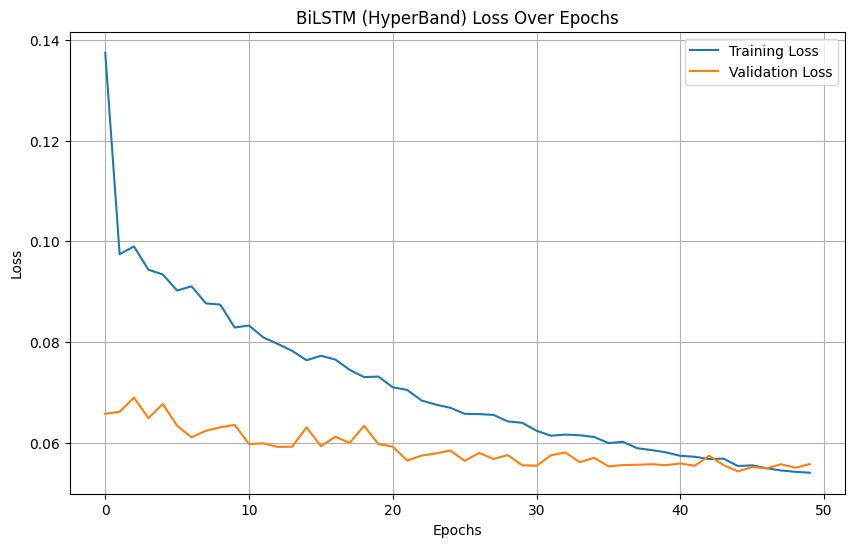

In [202]:
model_loss_plot(history_bilstm, "BiLSTM (HyperBand)")

In [203]:
bilstm_best_metrics_dict= evaluate_model(best_bilstm_model, X_test, y_test, scaler)
bilstm_best_metrics_dict

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


{'MAE': 4.150521047074155,
 'MSE': 31.4137842751593,
 'RMSE': 5.604800110187633,
 'MAPE': 2690296349460627.0,
 'R² Score': 0.5871771804574712}

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


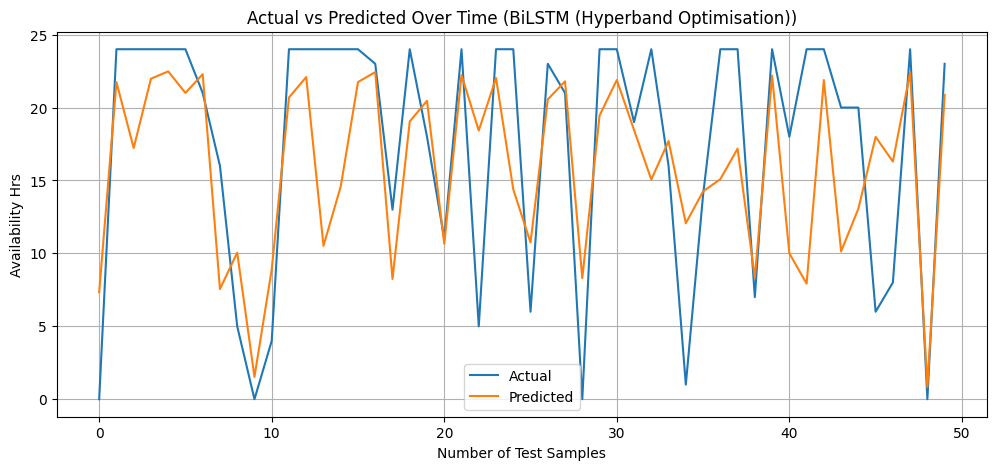

In [204]:
plot_actual_vs_predicted(best_bilstm_model, "BiLSTM (Hyperband Optimisation)")

#### BiLSTM Hyperparamters Tuning with Optuna

In [205]:
# Retrain BiLSTM model with Any Optimiser best_param_dicts

def train_best_bilstm_model(params, Optimiser_name="Dragonfly"):
    """
    Args:
    Param: params: dict of best hyperparameters from optimiser,
    Optimiser_name: name of the optimiser (for printing)
       
    Return: trained model and training history"""
    
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build BiLSTM model with given hyperparameters
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=(num_layers > 1)), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(Bidirectional(LSTM(hidden_units, return_sequences=(i < num_layers - 1))))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])

    print(f"{Optimiser_name} Model Architecture:")
    model.summary()
    
    # Train the model
    print(f"\n Training {Optimiser_name} Model with best hyperparameters...")
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 1, epochs=50)
    
    return model, history

In [206]:
import optuna

def objective_optuna(trial):
    # Suggest hyperparameters
    hidden_units = trial.suggest_int("hidden_units", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    # Build BiLSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=(num_layers > 1), input_shape=input_shape)))
    for i in range(1, num_layers):
        model.add(Bidirectional(LSTM(hidden_units, return_sequences=(i < num_layers - 1))))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    # Train
    model.fit(X_train, y_train,
              epochs=20,
              batch_size=batch_size,
              validation_split=0.2,
              verbose=0)

    # Predict & evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Run optimisation
study = optuna.create_study(direction="minimize")
study.optimize(objective_optuna, n_trials=20)

print("Best Params:", study.best_trial.params)
print("Best RMSE:", study.best_trial.value)

[I 2025-10-19 19:35:29,827] A new study created in memory with name: no-name-1a5e3c09-b237-486c-a8f5-06bdc205a6ba
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


[I 2025-10-19 19:37:59,398] Trial 0 finished with value: 5.776296500192799 and parameters: {'hidden_units': 56, 'num_layers': 3, 'dropout_rate': 0.4686432921828798, 'learning_rate': 0.0016169680045885694, 'batch_size': 62}. Best is trial 0 with value: 5.776296500192799.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


[I 2025-10-19 19:43:57,768] Trial 1 finished with value: 5.3743820715742325 and parameters: {'hidden_units': 113, 'num_layers': 3, 'dropout_rate': 0.3763852128120702, 'learning_rate': 0.0012167971850435134, 'batch_size': 33}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


[I 2025-10-19 19:47:03,942] Trial 2 finished with value: 5.715098676638275 and parameters: {'hidden_units': 81, 'num_layers': 3, 'dropout_rate': 0.029094684052480946, 'learning_rate': 0.0004838868063344746, 'batch_size': 81}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-10-19 19:47:33,269] Trial 3 finished with value: 5.869967902183882 and parameters: {'hidden_units': 55, 'num_layers': 1, 'dropout_rate': 0.49274656579100523, 'learning_rate': 0.00011206383584925299, 'batch_size': 103}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


[I 2025-10-19 19:53:55,222] Trial 4 finished with value: 5.520393106228295 and parameters: {'hidden_units': 127, 'num_layers': 3, 'dropout_rate': 0.07602801309938317, 'learning_rate': 0.0005180346952243111, 'batch_size': 27}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step


[I 2025-10-19 19:58:23,218] Trial 5 finished with value: 5.450750595102942 and parameters: {'hidden_units': 114, 'num_layers': 3, 'dropout_rate': 0.21003840719565903, 'learning_rate': 0.005550967425583212, 'batch_size': 39}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-10-19 19:58:59,355] Trial 6 finished with value: 5.58365565023247 and parameters: {'hidden_units': 65, 'num_layers': 1, 'dropout_rate': 0.3274957275986682, 'learning_rate': 0.0058624239127222574, 'batch_size': 118}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


[I 2025-10-19 20:00:42,587] Trial 7 finished with value: 5.846308506978618 and parameters: {'hidden_units': 43, 'num_layers': 3, 'dropout_rate': 0.38803172999115426, 'learning_rate': 0.00036356115787569243, 'batch_size': 52}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


[I 2025-10-19 20:01:25,323] Trial 8 finished with value: 5.651829132515993 and parameters: {'hidden_units': 76, 'num_layers': 1, 'dropout_rate': 0.1168400964924971, 'learning_rate': 0.0016852557115792314, 'batch_size': 123}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2025-10-19 20:02:21,785] Trial 9 finished with value: 5.524441625136769 and parameters: {'hidden_units': 122, 'num_layers': 1, 'dropout_rate': 0.09925517025146602, 'learning_rate': 0.007029809243853578, 'batch_size': 123}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2025-10-19 20:04:25,504] Trial 10 finished with value: 5.462866210512565 and parameters: {'hidden_units': 17, 'num_layers': 2, 'dropout_rate': 0.2592036779949347, 'learning_rate': 0.0023402986312704988, 'batch_size': 17}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


[I 2025-10-19 20:06:53,787] Trial 11 finished with value: 5.572523044835084 and parameters: {'hidden_units': 103, 'num_layers': 2, 'dropout_rate': 0.19492292619122067, 'learning_rate': 0.0036766691024998892, 'batch_size': 39}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


[I 2025-10-19 20:09:42,788] Trial 12 finished with value: 5.5333177617977265 and parameters: {'hidden_units': 100, 'num_layers': 2, 'dropout_rate': 0.2121690979648628, 'learning_rate': 0.0010045218220704913, 'batch_size': 45}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step


[I 2025-10-19 20:19:04,250] Trial 13 finished with value: 5.421271737625606 and parameters: {'hidden_units': 103, 'num_layers': 3, 'dropout_rate': 0.3432542351186193, 'learning_rate': 0.008877159127311816, 'batch_size': 79}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


[I 2025-10-19 20:29:46,085] Trial 14 finished with value: 5.811947522296978 and parameters: {'hidden_units': 95, 'num_layers': 3, 'dropout_rate': 0.3896519779828692, 'learning_rate': 0.0001646578868249149, 'batch_size': 83}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


[I 2025-10-19 20:33:35,838] Trial 15 finished with value: 5.59128873433786 and parameters: {'hidden_units': 90, 'num_layers': 2, 'dropout_rate': 0.34062263596951553, 'learning_rate': 0.009113769176939566, 'batch_size': 97}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step


[I 2025-10-19 20:43:26,503] Trial 16 finished with value: 5.8591147581270295 and parameters: {'hidden_units': 111, 'num_layers': 3, 'dropout_rate': 0.29570904436272194, 'learning_rate': 0.0008386561793744655, 'batch_size': 69}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step


[I 2025-10-19 20:48:54,840] Trial 17 finished with value: 5.61722595486249 and parameters: {'hidden_units': 112, 'num_layers': 2, 'dropout_rate': 0.42356410832864966, 'learning_rate': 0.0033317050578337325, 'batch_size': 96}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step


[I 2025-10-19 20:55:23,571] Trial 18 finished with value: 5.761007934831015 and parameters: {'hidden_units': 86, 'num_layers': 3, 'dropout_rate': 0.42546185754496907, 'learning_rate': 0.00021878334963242708, 'batch_size': 57}. Best is trial 1 with value: 5.3743820715742325.
C:\Users\pc\AppData\Local\Temp\ipykernel_8024\3270475318.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step


[I 2025-10-19 21:04:46,837] Trial 19 finished with value: 5.695223805632418 and parameters: {'hidden_units': 128, 'num_layers': 3, 'dropout_rate': 0.3394839467759337, 'learning_rate': 0.0009115834823041477, 'batch_size': 82}. Best is trial 1 with value: 5.3743820715742325.


Best Params: {'hidden_units': 113, 'num_layers': 3, 'dropout_rate': 0.3763852128120702, 'learning_rate': 0.0012167971850435134, 'batch_size': 33}
Best RMSE: 5.3743820715742325


In [207]:
bilstm_optuna_model, bilstm_optuna_history = train_best_lstm_model(study.best_trial.params, "Optuna")

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optuna Model Architecture:


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_213 (LSTM)                 │ (None, 24, 113)        │        54,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_214 (LSTM)                 │ (None, 24, 113)        │       102,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 24, 16)         │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_215 (LSTM)                 │ (None, 113)            │        58,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 16)             │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,721 (858.29 KB)

 Trainable params: 219,721 (858.29 KB)

 Non-trainable params: 0 (0.00 B)


 Training Optuna Model with best hyperparameters...
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 0.5287 - root_mean_squared_error: 0.4465 - val_loss: 0.1197 - val_root_mean_squared_error: 0.2755
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.1416 - root_mean_squared_error: 0.3329 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2702
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.1077 - root_mean_squared_error: 0.3127 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2616
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0960 - root_mean_squared_error: 0.3014 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2674
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.0876 - root_mean_squared_error: 0.2905 - val_loss: 0.0707 - val_root_mean_squared_error: 0.2606
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 0.0864 - root_mean_squared_error: 0.2894 - val_loss: 0.0735 - val_root_mean_squared

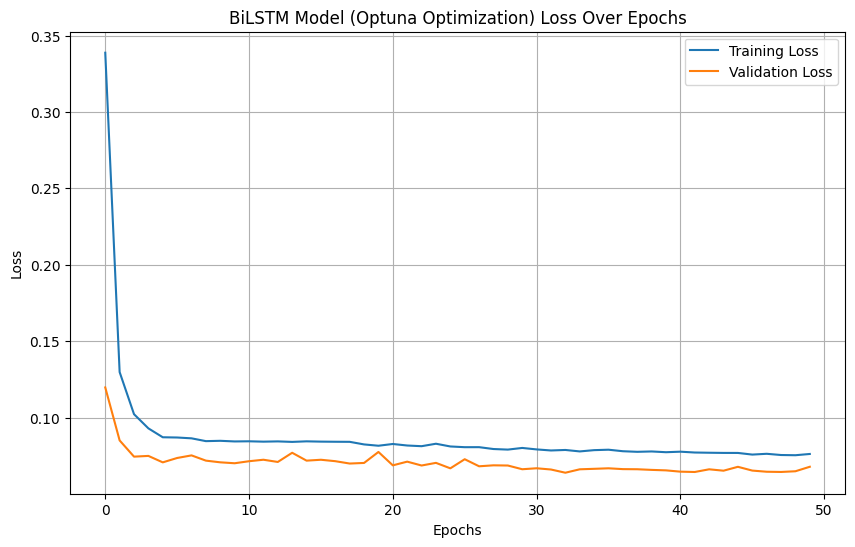

In [208]:
model_loss_plot(bilstm_optuna_history, "BiLSTM Model (Optuna Optimization)")

In [209]:
# Evaluate the Optuna model
bilstm_optuna_metrics = evaluate_model(bilstm_optuna_model, X_test, y_test, scaler)
bilstm_optuna_metrics

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


{'MAE': 4.584496675767804,
 'MSE': 36.78902609344731,
 'RMSE': 6.065395790337784,
 'MAPE': 4826597630947249.0,
 'R² Score': 0.5165386841938017}

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


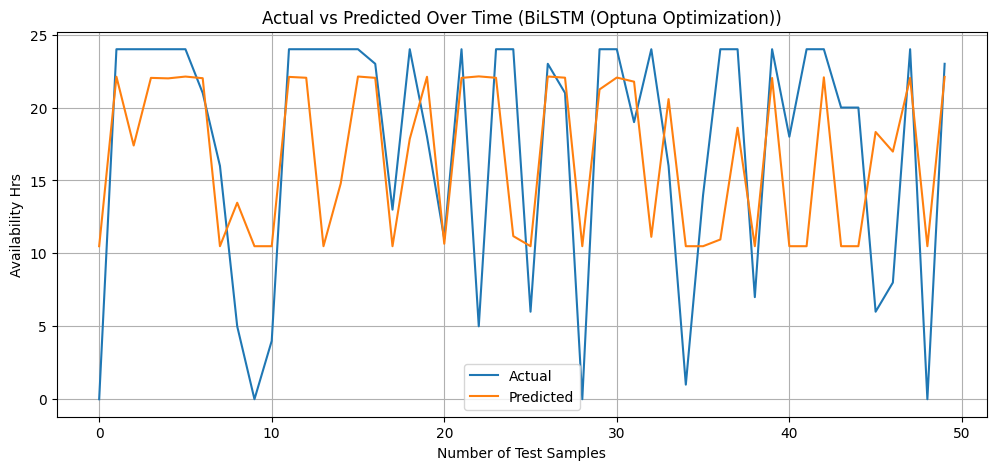

In [210]:
plot_actual_vs_predicted(bilstm_optuna_model, "BiLSTM (Optuna Optimization)")

#### DragonFly Optimization with BiLSTM

In [211]:
# Objective function for Dragonfly
def objective_function(params):
    params= dict(zip(param_names, params))
    print("\n Evaluating with params:", params)
    hidden_units= int(params['hidden_units'])
    num_layers= int(params['num_layers'])
    dropout_rate= params['dropout_rate']
    learning_rate= params['learning_rate']
    batch_size= int(params['batch_size'])
    
    # Build BiLSTM model with given hyperparameters
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=(num_layers > 1)), input_shape=input_shape))
    for i in range(1, num_layers):
        model.add(Bidirectional(LSTM(hidden_units, return_sequences=(i < num_layers - 1))))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    
    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0),
                  metrics=[RootMeanSquaredError()])
    
    # Train the model
    model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size,
                        verbose= 0, epochs=50)
        
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    return rmse


##### Bayesian DragonFly Optimiser

In [212]:
# # Run Dragonfly optimization with Bayesian optimization (Default is 'bo')
# bay_val, bay_params, history = minimise_function(
#     objective_function, domain, max_capital=20
# )

# best_params_dict = dict(zip(param_names, bay_params))
# print("Best Bayesian Parameters:", best_params_dict)
# print("Best RMSE:", bay_val)

In [213]:
# # Retrain model with the Dragonfly best parameters
# dragonfly_bay_bilstm_model, dragonfly_history = train_best_bilstm_model(best_params_dict, "BiLSTM Dragonfly (Bayesian Method)")

In [214]:
# model_loss_plot(dragonfly_history, "BiLSTM Dragonfly (Bayesian Method) Optimization")

In [215]:
# # Evaluate the Dragonfly model
# dragonfly_bay_metrics_dict = evaluate_model(dragonfly_bay_bilstm_model, X_test, y_test, scaler)
# dragonfly_bay_metrics_dict

In [216]:
# plot_actual_vs_predicted(dragonfly_bay_bilstm_model, "BiLSTM Dragonfly (Bayesian Method)")

##### Random DragonFly Optimiser

In [217]:
# Run Dragonfly optimization with Random Method (Default is 'rand')
rand_val, rand_params, rand_history = minimise_function(
    objective_function, domain, max_capital=20, opt_method='rand'
)

rand_params_dict = dict(zip(param_names, rand_params))
print("Best Parameters:", rand_params_dict)
print("Best RMSE:", rand_val)

Optimisation with rand using capital 20.0 (return_value)



 Evaluating with params: {'hidden_units': np.float64(81.05496211111253), 'num_layers': np.float64(1.2209747313865744), 'dropout_rate': np.float64(0.20359500127391927), 'learning_rate': np.float64(0.007156564996475339), 'batch_size': np.float64(127.71319781387888)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 5.933192219710144

 Evaluating with params: {'hidden_units': np.float64(124.67650814982436), 'num_layers': np.float64(2.091953644982542), 'dropout_rate': np.float64(0.2860919152524139), 'learning_rate': np.float64(0.0078332320703361), 'batch_size': np.float64(19.67327800185774)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
RMSE: 5.87838342781014

 Evaluating with params: {'hidden_units': np.float64(124.22259586972217), 'num_layers': np.float64(1.6088215448128604), 'dropout_rate': np.float64(0.3038432543522438), 'learning_rate': np.float64(0.008349346363148411), 'batch_size': np.float64(91.91336899282545)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
RMSE: 6.1721355323389195

 Evaluating with params: {'hidden_units': np.float64(96.72091888886145), 'num_layers': np.float64(2.928245676223536), 'dropout_rate': np.float64(0.25683867355749584), 'learning_rate': np.float64(0.004243098141013263), 'batch_size': np.float64(44.98485232523923)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
RMSE: 5.900153408921055

 Evaluating with params: {'hidden_units': np.float64(29.199278109646738), 'num_layers': np.float64(1.86399189825356), 'dropout_rate': np.float64(0.012370537614982302), 'learning_rate': np.float64(0.004401880482329486), 'batch_size': np.float64(37.303295292770116)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE: 5.899304022266022
Capital spent on initialisation: 5.0000(0.2500).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>

 Evaluating with params: {'hidden_units': np.float64(104.55915932432603), 'num_layers': np.float64(1.8891007213188673), 'dropout_rate': np.float64(0.46111502907293117), 'learning_rate': np.float64(0.007937022874953304), 'batch_size': np.float64(35.490185563546405)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 6.06809564586179

 Evaluating with params: {'hidden_units': np.float64(38.86005063987978), 'num_layers': np.float64(2.1866830934720145), 'dropout_rate': np.float64(0.06026194397157142), 'learning_rate': np.float64(0.006630649264981388), 'batch_size': np.float64(92.71937212072787)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
RMSE: 5.603177489207226

 Evaluating with params: {'hidden_units': np.float64(50.23622852613818), 'num_layers': np.float64(2.809967972195775), 'dropout_rate': np.float64(0.03994485291103533), 'learning_rate': np.float64(0.007587204184252025), 'batch_size': np.float64(55.141254641173745)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
RMSE: 5.972074632895434

 Evaluating with params: {'hidden_units': np.float64(85.96871510903398), 'num_layers': np.float64(2.049945231034351), 'dropout_rate': np.float64(0.05281346103569812), 'learning_rate': np.float64(0.00058588125353627), 'batch_size': np.float64(108.83572980005056)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
RMSE: 5.6142055615449955

 Evaluating with params: {'hidden_units': np.float64(121.36342496030328), 'num_layers': np.float64(1.0694933786077068), 'dropout_rate': np.float64(0.4163062952337222), 'learning_rate': np.float64(0.009892372575288013), 'batch_size': np.float64(125.04320824916853)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
RMSE: 5.481305841201116

 Evaluating with params: {'hidden_units': np.float64(39.440547954423714), 'num_layers': np.float64(2.6208369187882834), 'dropout_rate': np.float64(0.2645536058040288), 'learning_rate': np.float64(0.0044943121936197065), 'batch_size': np.float64(87.59110425582817)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
RMSE: 5.630063179155681

 Evaluating with params: {'hidden_units': np.float64(48.62138574981894), 'num_layers': np.float64(2.5820600409467906), 'dropout_rate': np.float64(0.1121229923467883), 'learning_rate': np.float64(0.002212281634790021), 'batch_size': np.float64(91.49111310640023)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
RMSE: 5.482707806237744
#013 (011, 0.550):: curr_max=-5.48131, 

 Evaluating with params: {'hidden_units': np.float64(101.24289088169071), 'num_layers': np.float64(2.0158917940918863), 'dropout_rate': np.float64(0.22031185766121653), 'learning_rate': np.float64(0.004925687818555114), 'batch_size': np.float64(96.50991549157123)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
RMSE: 5.434231742083832

 Evaluating with params: {'hidden_units': np.float64(48.601097777958344), 'num_layers': np.float64(1.3455493066276067), 'dropout_rate': np.float64(0.3649330383589563), 'learning_rate': np.float64(0.009488196704112592), 'batch_size': np.float64(100.04631942729142)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 5.893799568592824

 Evaluating with params: {'hidden_units': np.float64(33.98354304061653), 'num_layers': np.float64(1.0929813146694143), 'dropout_rate': np.float64(0.4520135601319594), 'learning_rate': np.float64(0.0045231192045820535), 'batch_size': np.float64(91.94130272277464)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 5.609269016332695

 Evaluating with params: {'hidden_units': np.float64(32.84518713666418), 'num_layers': np.float64(2.9708486145825725), 'dropout_rate': np.float64(0.15838823869873675), 'learning_rate': np.float64(0.007220783800210875), 'batch_size': np.float64(89.09132116980089)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
RMSE: 5.474445021686837

 Evaluating with params: {'hidden_units': np.float64(112.55210598123541), 'num_layers': np.float64(2.5074002178843533), 'dropout_rate': np.float64(0.3474655929848256), 'learning_rate': np.float64(0.005207292045556056), 'batch_size': np.float64(71.97847288548034)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
RMSE: 5.524046582560161

 Evaluating with params: {'hidden_units': np.float64(84.12072629928588), 'num_layers': np.float64(1.4515349070095316), 'dropout_rate': np.float64(0.0520888690745957), 'learning_rate': np.float64(0.002202894186116818), 'batch_size': np.float64(58.33023226250537)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 5.994903499095918

 Evaluating with params: {'hidden_units': np.float64(119.58756054773231), 'num_layers': np.float64(1.2278822111454462), 'dropout_rate': np.float64(0.19242565484576374), 'learning_rate': np.float64(0.005349089767768712), 'batch_size': np.float64(62.886938325529094)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
RMSE: 6.237634102013776

 Evaluating with params: {'hidden_units': np.float64(23.815703609112518), 'num_layers': np.float64(1.0777465761490632), 'dropout_rate': np.float64(0.20846223755859344), 'learning_rate': np.float64(0.003348302535693552), 'batch_size': np.float64(30.392461195353032)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
RMSE: 5.818821716879936

 Evaluating with params: {'hidden_units': np.float64(55.502043839048625), 'num_layers': np.float64(2.3141261196047735), 'dropout_rate': np.float64(0.32419358604185955), 'learning_rate': np.float64(0.0005321468839209035), 'batch_size': np.float64(54.90152545258255)}


c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
RMSE: 5.55700510148522
#022 (021, 1.050):: curr_max=-5.43423, 
Best Parameters: {'hidden_units': np.float64(101.24289088169071), 'num_layers': np.float64(2.0158917940918863), 'dropout_rate': np.float64(0.22031185766121653), 'learning_rate': np.float64(0.004925687818555114), 'batch_size': np.float64(96.50991549157123)}
Best RMSE: 5.434231742083832


In [218]:
# Retrain model with the Dragonfly best parameters
dragonfly_rand_bilstm_model, dragonfly_history = train_best_bilstm_model(best_params_dict, "BiLSTM Dragonfly (Random Method)")

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Optimization of Power System Avaliability\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


BiLSTM Dragonfly (Random Method) Model Architecture:


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_92                │ (None, 24, 82)         │        16,072 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_93                │ (None, 82)             │        40,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 16)             │         1,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,089 (226.91 KB)

 Trainable params: 58,089 (226.91 KB)

 Non-trainable params: 0 (0.00 B)


 Training BiLSTM Dragonfly (Random Method) Model with best hyperparameters...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.3942 - root_mean_squared_error: 0.3896 - val_loss: 0.2234 - val_root_mean_squared_error: 0.2545
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.2036 - root_mean_squared_error: 0.2543 - val_loss: 0.1536 - val_root_mean_squared_error: 0.2526
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.1399 - root_mean_squared_error: 0.2479 - val_loss: 0.1139 - val_root_mean_squared_error: 0.2514
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1065 - root_mean_squared_error: 0.2487 - val_loss: 0.0939 - val_root_mean_squared_error: 0.2532
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0915 - root_mean_squared_error: 0.2547 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2511
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0827 - root_mean_squared_error: 0.2572 - val_loss: 0.0755 - val_root_mean_

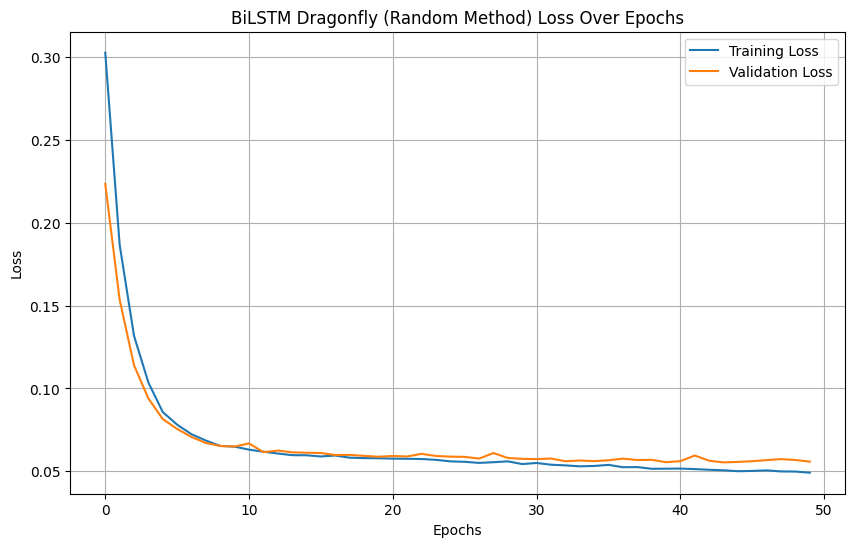

In [219]:
model_loss_plot(dragonfly_history, "BiLSTM Dragonfly (Random Method)")

In [220]:
# Evaluate the Dragonfly model
dragonfly_rand_bilstm_metrics = evaluate_model(dragonfly_rand_bilstm_model, X_test, y_test, scaler)
dragonfly_rand_bilstm_metrics

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


{'MAE': 3.722878801891281,
 'MSE': 30.09808541199736,
 'RMSE': 5.486172200359497,
 'MAPE': 2609152012458904.5,
 'R² Score': 0.6044673773214293}

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


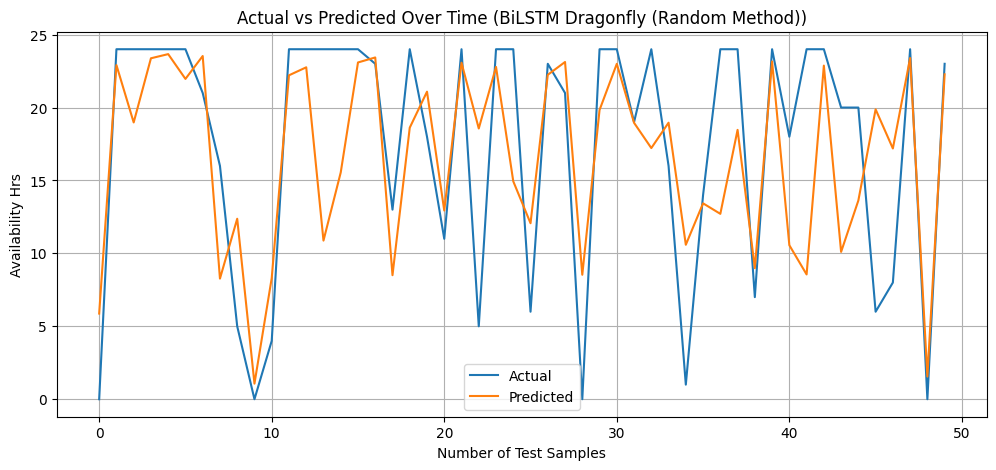

In [221]:
plot_actual_vs_predicted(dragonfly_rand_bilstm_model, "BiLSTM Dragonfly (Random Method)")

##### Direct DragonFly Optimiser

In [222]:
# from dragonfly.apis.opt import maximise_function
    
#     # Create a wrapper that negates the objective (since maximise_function maximizes)
# def neg_objective_function(params):
#         return -objective_function(params)
    
# max_val, direct_params, _ = maximise_function(
#          neg_objective_function, domain, max_capital=20, opt_method='direct'
#     )
# direct_val = -max_val  # Convert back to minimization
# direct_params_dict = dict(zip(param_names, direct_params))
# direct_history = None  # Set history to None
        
# print("Best Parameters:", direct_params_dict)
# print("Best RMSE:", direct_val)        
        

In [223]:
# # Run Dragonfly optimization with Direct Method (Default is 'direct')
# direct_val, direct_params, direct_history = minimise_function(
#     objective_function, domain, max_capital=20, opt_method='direct'
# )

# direct_params_dict = dict(zip(param_names, direct_params))
# print("Best Parameters:", direct_params_dict)
# print("Best RMSE:", direct_val)

In [224]:
# # Retrain model with the Dragonfly best parameters
# dragonfly_direct_bilstm_model, dragonfly_history = train_best_bilstm_model(best_params_dict, "BiLSTM Dragonfly (Direct Method)")

In [225]:
# model_loss_plot(dragonfly_history, "BiLSTM Dragonfly (Direct Method) Optimization")

In [226]:
# # Evaluate the Dragonfly model
# dragonfly_direct_bilstm_metrics = evaluate_model(dragonfly_direct_bilstm_model, X_test, y_test, scaler)
# dragonfly_direct_bilstm_metrics

In [227]:
# plot_actual_vs_predicted(dragonfly_direct_bilstm_model, "BiLSTM Dragonfly (Direct Method)")

##### PDOO DragonFly Optimiser

"PDOO" stands for "Parallel Dividing Optimistic Optimization" and is a deterministic global optimization algorithm that belongs to the family of "optimistic optimization" methods.

In [228]:
# # Run Dragonfly optimization with Pdoo process (Default is 'bo')
# pdoo_val, pdoo_params, pdoo_history = minimise_function(
#     objective_function, domain, max_capital=20, opt_method='pdoo'
# )

# pdoo_params_dict = dict(zip(param_names, pdoo_params))
# print("Best Parameters:", pdoo_params_dict)
# print("Best RMSE:", pdoo_val)

In [229]:
# # Retrain model with the Dragonfly best parameters
# dragonfly_pdoo_bilstm_model, dragonfly_history = train_best_bilstm_model(pdoo_params_dict, "BiLSTM Dragonfly (Pdoo Method)")

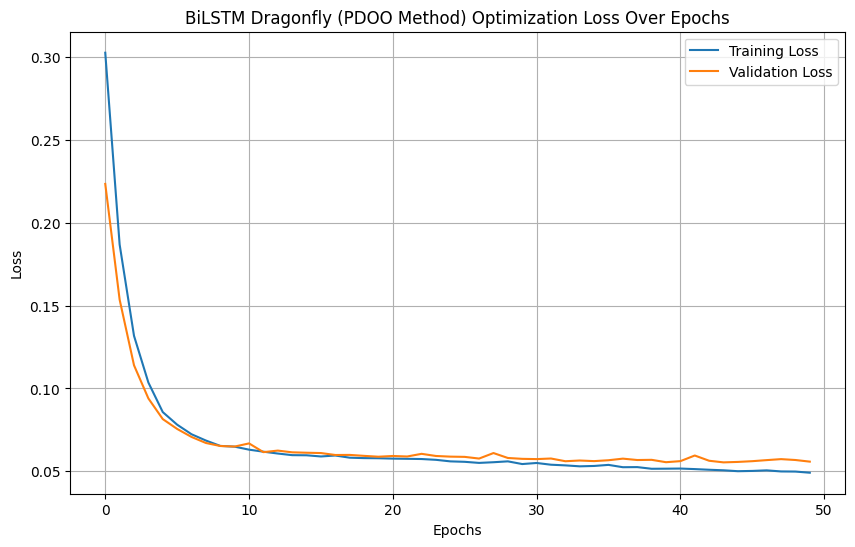

In [230]:
model_loss_plot(dragonfly_history, "BiLSTM Dragonfly (PDOO Method) Optimization")

In [231]:
# # Evaluate the Dragonfly model
# dragonfly_pdoo_metrics_dict = evaluate_model(dragonfly_pdoo_bilstm_model, X_test, y_test, scaler)
# dragonfly_pdoo_metrics_dict

In [232]:
# plot_actual_vs_predicted(dragonfly_pdoo_bilstm_model, "BiLSTM Dragonfly (PDOO Method)")

### Model Comparison

#### Without Optimisation 

In [233]:
metrics_base_path = os.path.join('..', 'model_metrics')
if not os.path.exists(metrics_base_path):
    os.makedirs(metrics_base_path)

In [234]:
#Create a dataframe to compare all models' metrics
model_metrics= {
    "Linear Regression": lr_metrics_dict,
    "XGBoost": xgb_metrics_dict,
    "LSTM": lstm_metrics_dict,
    "GRU": gru_metrics_dict,
    "BiLSTM": bilstm_metrics_dict
}

metrics_df= pd.DataFrame(model_metrics).T
metrics_df


,MAE,MSE,RMSE,MAPE,R² Score
Linear Regression,3.908199,27.195787,5.214958,1.783361e+15,0.637234
XGBoost,1.643294,7.444758,2.728508,2.580198e+14,0.900694
LSTM,3.929209,37.495693,6.123373,3.297389e+15,0.507252
GRU,3.988482,32.899385,5.735799,3.121542e+15,0.567654
BiLSTM,4.427778,35.168578,5.930310,3.258555e+15,0.537834


In [244]:
#Drop MSE and sort by MSE
metrics_df_sorted = metrics_df.drop(columns=['MAPE'])
#metrics_df_sorted = metrics_df.sort_values(by='MSE', ascending=True)
metrics_df_sorted

,MAE,MSE,RMSE,R² Score
Linear Regression,3.908199,27.195787,5.214958,0.637234
XGBoost,1.643294,7.444758,2.728508,0.900694
LSTM,3.929209,37.495693,6.123373,0.507252
GRU,3.988482,32.899385,5.735799,0.567654
BiLSTM,4.427778,35.168578,5.930310,0.537834


In [245]:
metrics_df.to_csv(os.path.join(metrics_base_path, 'model_metrics.csv'))


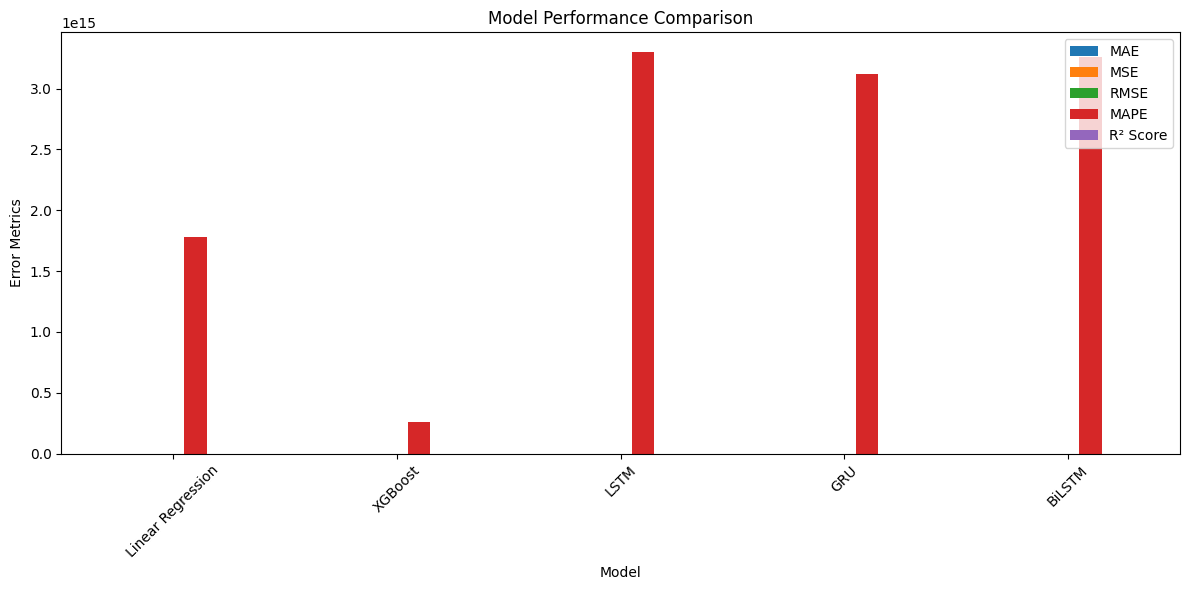

In [237]:
#Plot the metrics
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


#### With All Optimisation

In [238]:
# # Do comparison for all model's Optimsation
best_model_metrics= {
    "LSTM Hyperband": lstm_best_metrics_dict,
    "GRU Hyperband": gru_best_metrics_dict,
    "BiLSTM Hyperband": bilstm_best_metrics_dict,
    "LSTM Dragonfly": dragonfly_lstm_metrics_dict,
    "GRU Dragonfly": dragonfly_gru_metrics_dict,
    "BiLSTM Dragonfly": dragonfly_rand_bilstm_metrics,
    "LSTM Optuna": lstm_optuna_metrics,
    "GRU Optuna": gru_optuna_metrics,
    "BiLSTM Optuna": bilstm_optuna_metrics,

}
best_model_metrics = pd.DataFrame(best_model_metrics).T
best_model_metrics

,MAE,MSE,RMSE,MAPE,R² Score
LSTM Hyperband,3.763675,29.907462,5.468772,2.924231e+15,0.606972
GRU Hyperband,3.837738,31.015521,5.569158,3.176200e+15,0.592411
BiLSTM Hyperband,4.150521,31.413784,5.604800,2.690296e+15,0.587177
LSTM Dragonfly,3.779557,31.364659,5.600416,2.622802e+15,0.587823
GRU Dragonfly,3.877344,30.793133,5.549156,2.744947e+15,0.595333
BiLSTM Dragonfly,3.722879,30.098085,5.486172,2.609152e+15,0.604467
LSTM Optuna,4.063699,36.675247,6.056009,2.840705e+15,0.518034
GRU Optuna,3.963931,31.960583,5.653369,3.875901e+15,0.579991
BiLSTM Optuna,4.584497,36.789026,6.065396,4.826598e+15,0.516539


In [239]:
#Drop MSE and sort by MSE
best_model_metrics_df = metrics_df.drop(columns=['MAPE']).sort_values(by='RMSE', ascending=True)
#metrics_df_sorted = metrics_df.sort_values(by='MSE', ascending=True)
best_model_metrics_df

,MAE,MSE,RMSE,R² Score
XGBoost,1.643294,7.444758,2.728508,0.900694
Linear Regression,3.908199,27.195787,5.214958,0.637234
GRU,3.988482,32.899385,5.735799,0.567654
BiLSTM,4.427778,35.168578,5.930310,0.537834
LSTM,3.929209,37.495693,6.123373,0.507252


In [240]:
best_model_metrics_df.to_csv(os.path.join(metrics_base_path, 'best_model_metrics.csv'))


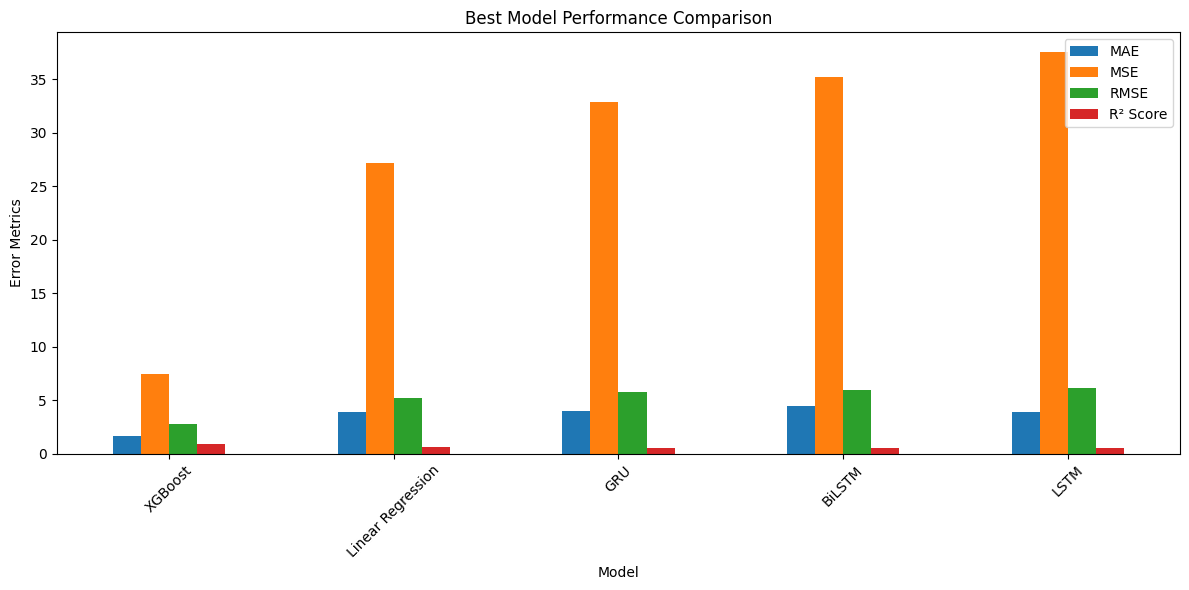

In [241]:
#Plot the best metrics
best_model_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Best Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Save the Best Model

In [242]:
# Save the best model
best_model_name= best_model_metrics_df.index[0]
if best_model_name == 'LSTM Hyperband':
    best_model = best_lstm_model
elif best_model_name == 'GRU Hyperband':
    best_model = best_gru_model
elif best_model_name == 'BiLSTM Hyperband':
    best_model = best_bilstm_model
elif best_model_name == 'LSTM Dragonfly':
    best_model = dragonfly_lstm_model
elif best_model_name == 'GRU Dragonfly':
    best_model = dragonfly_gru_model
elif best_model_name == 'BiLSTM Dragonfly':
    best_model = dragonfly_rand_bilstm_model
elif best_model_name == 'LSTM Optuna':
    best_model = lstm_optuna_model
elif best_model_name == 'GRU Optuna':
    best_model = gru_optuna_model
elif best_model_name == 'BiLSTM Optuna':
    best_model = bilstm_optuna_model    
else:
    raise ValueError("Unknown best model name")

ValueError: Unknown best model name

In [ ]:
# Save and dump best model using a valid Keras extension
best_model_path = os.path.join(metrics_base_path, f'{best_model_name}.keras')
best_model.save(best_model_path)